In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl
import pandas as pd
from tabulate import tabulate


from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.likelihood import BGSEstimator

2022-08-25 19:53:57.223796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [4]:
x = np.array([1.86992422e-03, 4.00359794e-09, 3.59295125e-09, 3.79554508e-09,
       1.00000000e-11, 1.69427020e-10, 2.24174830e-10, 1.00000000e-11,
       3.39025861e-10, 2.89829873e-10, 6.95557253e-10, 2.92180553e-10,
       2.59670812e-10, 3.87668965e-09, 1.17360710e-09, 9.77462096e-10])


In [5]:
2*x[1:].reshape((5, 3)).sum(axis=0)

array([1.71916897e-08, 1.11343836e-08, 1.10933654e-08])

# TODO

- `load_annot` below: should this be called?
- new neutral mask tracks?
- issue with odd normal LL

In [6]:
from bgspy.command_line import grid_maker

In [7]:
grid_maker(6, 5)

Grid(w=array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07]), t=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]))

In [8]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


In [9]:
gd = GenomeData(g)
gd.load_counts_dir('../data/h1kg/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [10]:
gd.stats()

{'chr1': (0.6437419477373434, 0.9783094569056748),
 'chr2': (0.5870489628151874, 0.9744006372688843),
 'chr3': (0.6293010576197523, 0.9586475862528016),
 'chr4': (0.5932240306216314, 0.9705595610178201),
 'chr5': (0.5797625887774984, 0.9597880907296792),
 'chr6': (0.5797259005786911, 0.9642869644510512),
 'chr7': (0.6579516885563214, 0.9623460832612318),
 'chr8': (0.6118077615115524, 0.9586602150512149),
 'chr9': (0.6450291885058012, 0.961703740468648),
 'chr10': (0.6283062090688115, 0.9581456808637165),
 'chr11': (0.6352933157215227, 0.9496619287733763),
 'chr12': (0.6272914737717847, 0.9504784490876701),
 'chr13': (0.6201949352598828, 0.9615264647906644),
 'chr14': (0.6542182139077045, 0.9616978924442815),
 'chr15': (0.693987948311888, 0.9509761573619855),
 'chr16': (0.6381502671982755, 0.9435455674996038),
 'chr17': (0.6403107801499688, 0.9195267123331354),
 'chr18': (0.5983902238162843, 0.8992202446372572),
 'chr19': (0.697669622046724, 0.899347663678441),
 'chr20': (0.615711488675

In [11]:
gd.load_fasta('../data/annotation/hg38.fa.gz')

In [12]:
wind = 1e6

In [13]:
bins, pi = gd.bin_pi(width=wind, filter_neutral=True, filter_accessible=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


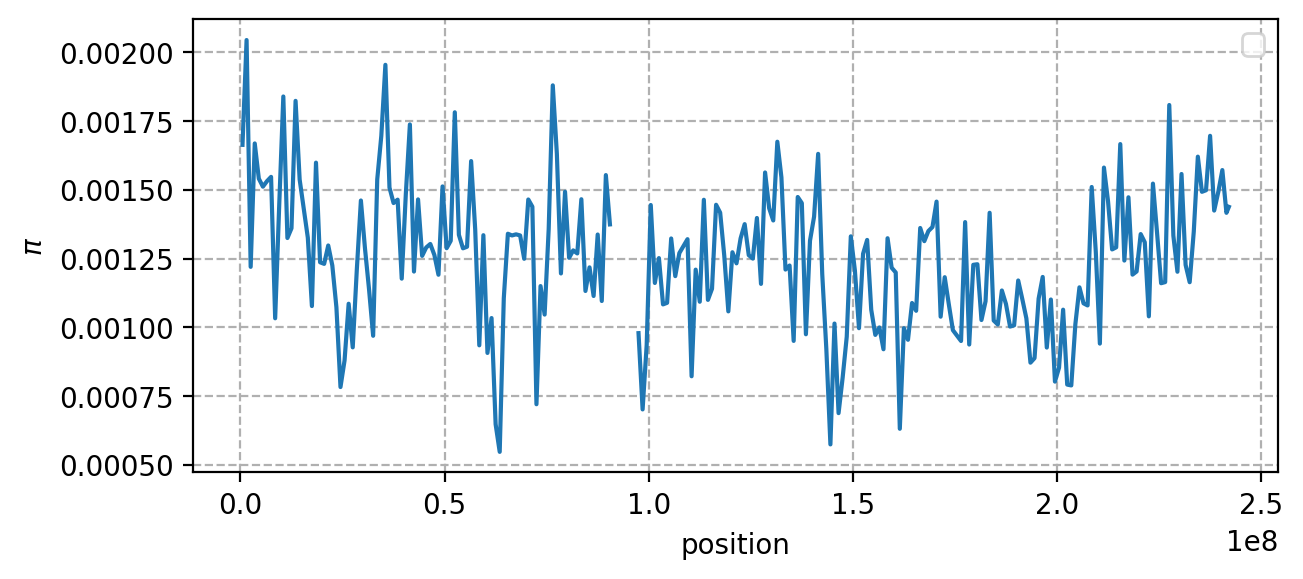

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr2'].pairs
ax.plot(x, y)

ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

## B Maps

In [15]:
#pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x4grid_10000step_10kN_mergedfeatures_old.pkl'
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_mergedfeatures.pkl'
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_genomiconly.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

In [19]:
pkl_balt_file = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_genomiconly_before_factor2.pkl'
m2 = BGSModel.load(pkl_balt_file)

In [20]:
bins, Y = gd.bin_reduce(wind, merge=True, filter_accessible=True, filter_neutral=True)

In [22]:
B = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bp = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bp2 = np.concatenate([m2.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

In [23]:
# This is test data for optimization / likelihood unit test
pickle.dump({'B': B, 'Bp': Bp, 'Y': Y, 'w': m.w, 't': m.t, 'bins':bins.flat}, open('../tests/likelihood_test_data.pkl', 'wb'))

In [24]:
# OLD BELOW 

In [21]:
chroms = np.array([int(c.replace('chr', '')) for c, _ in bins.flat])

ValueError: too many values to unpack (expected 2)

In [ ]:
def bin_recinfo(bins, recmap):
    chrom_i, midpoints = [], []
    ns = []
    for i, chrom in enumerate(bins):
        for j in range(1, len(bins[chrom])):
            chrom_i.append(i)
            pos = bins[chrom][j]
            midpoints.append(float(g.recmap.lookup(chrom, pos, cummulative=True)))
        ns.append(len(bins[chrom]))
    return np.array(chrom_i), np.array(midpoints), np.array(ns)

chrom_i, pos, ns = bin_recinfo(bins, g.recmap)

In [ ]:
len(chrom_i), Y.shape, len(pos), len(ns)

In [ ]:
B = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bp = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bp2 = np.concatenate([m2.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

In [ ]:
m.w, m.t

NameError: name 'pickle' is not defined

In [104]:
#mleBp.to_json2('../stan_experiments/bgs.json', chrom_i, pos, ns)
mleBp.to_json3('../stan_experiments/bgs.json', C)

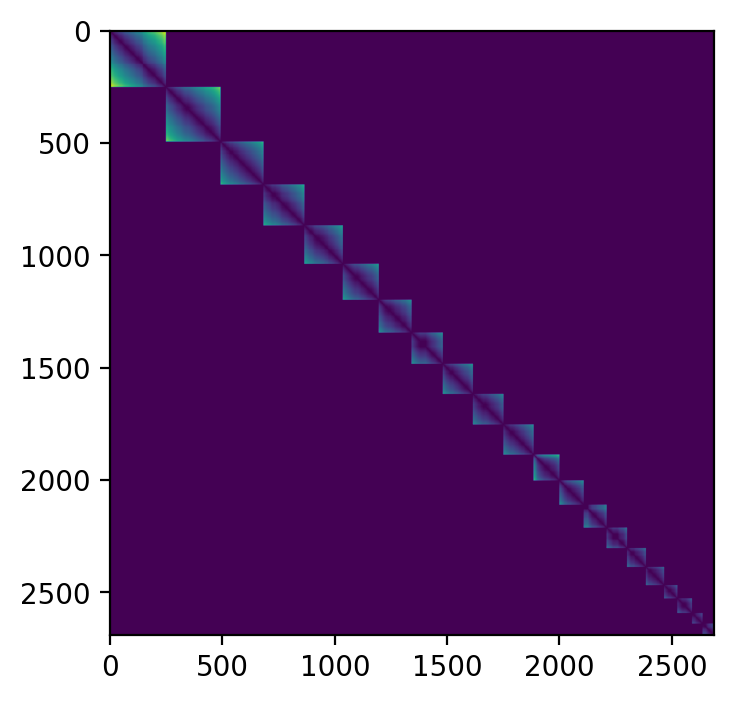

In [99]:
from scipy.spatial.distance import pdist, squareform


M = squareform(pdist(pos[:, None]))
C = squareform(pdist(chrom_i[:, None]))
M[C != 0.] = 0


In [97]:
C

array([[ 0.,  0.,  0., ..., 20., 20., 20.],
       [ 0.,  0.,  0., ..., 20., 20., 20.],
       [ 0.,  0.,  0., ..., 20., 20., 20.],
       ...,
       [20., 20., 20., ...,  0.,  0.,  0.],
       [20., 20., 20., ...,  0.,  0.,  0.],
       [20., 20., 20., ...,  0.,  0.,  0.]])

In [ ]:
def gp_cov(bins, recmap):
    chroms, pos, ns = bin_recinfo(bins, recmap)
    
    np.empty()

In [19]:
mleBp = BGSEstimator(m.w, m.t, Bp, (-5, -1))
mleBp.Y_ = Y
mleBp.to_json('../stan_experiments/bgs.json')

In [24]:
Y[Y[:, 1] > 0, :].min(axis=0)

array([7.97627859e+08, 8.03048000e+05])

In [16]:
np.round(mleBp.mle_W, 3)

array([[ 0.736, -0.051, -0.18 ],
       [ 0.   ,  0.943,  1.   ],
       [ 0.041,  0.079,  0.042],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.224,  0.028,  0.137]])

In [26]:
mleBp.bounds()

[(1e-05, 0.1),
 (1e-11, 1e-07),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]

In [23]:
mleBp.theta_[2:].reshape((4, 3))

array([[0.91130107, 0.51750865, 0.77068891],
       [0.87639841, 0.37398726, 0.70221206],
       [0.78527859, 0.66438481, 0.56909644],
       [0.75652626, 0.88814318, 0.57637194]])

In [24]:
mleBp.nll_

913745080437.8215

(array([ 6.,  2.,  3.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  0.,  4.,  1.,  1.,  5.,  8.,  9.,  2.,
         7., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([9.13922940e+11, 9.13923437e+11, 9.13923934e+11, 9.13924432e+11,
        9.13924929e+11, 9.13925426e+11, 9.13925923e+11, 9.13926421e+11,
        9.13926918e+11, 9.13927415e+11, 9.13927912e+11, 9.13928410e+11,
        9.13928907e+11, 9.13929404e+11, 9.13929901e+11, 9.13930398e+11,
        9.13930896e+11, 9.13931393e+11, 9.13931890e+11, 9.13932387e+11,
        9.13932885e+11, 9.13933382e+11, 9.13933879e+11, 9.13934376e+11,
  

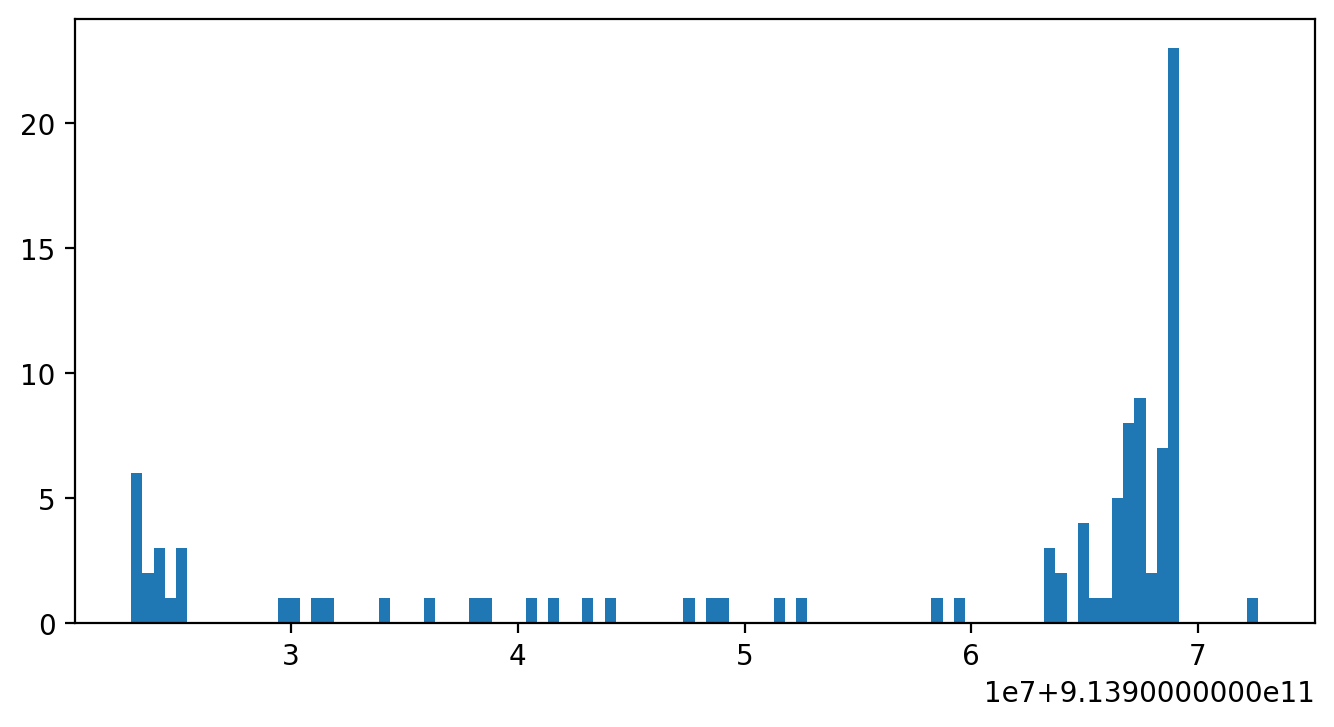

In [899]:
plt.hist(mleBp.nlls_, 100)

In [904]:
mleBp.random_start(simplex=True)

array([[6.68099128e-02],
       [3.85809236e-08],
       [9.23116269e-01],
       [2.90301961e-01],
       [1.06279396e-01],
       [2.30514218e-01],
       [6.41349395e-01],
       [2.55450879e-01],
       [2.89737026e-01],
       [3.24139515e-01],
       [6.26365906e-01],
       [4.42491591e-01],
       [4.75148726e-01],
       [5.09081018e-01]])

In [902]:
mleBp.theta_[2:].reshape((4, 3))

ValueError: cannot reshape array of size 14 into shape (4,3)

In [ ]:
mus = np.linspace(0.5, 3, 10)
best_thetas = []
best_nlls = []
for mu in mus:
    res = mleBp.fit(Y, 100, ncores=70, mu=mu * 1e-8) #mu=1.13e-8)
    best_thetas.append(res.theta_)
    best_nlls.append(res.nll_)

ERROR! Session/line number was not unique in database. History logging moved to new session 1780


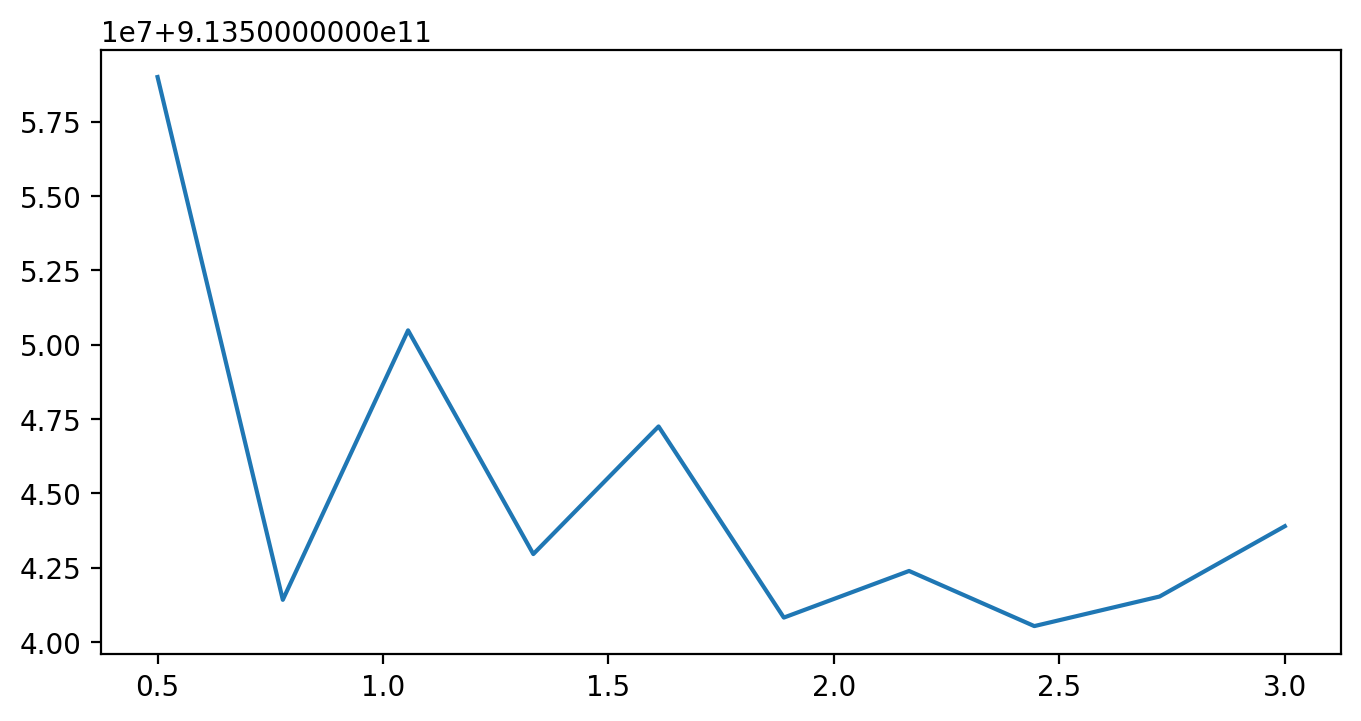

In [873]:
plt.plot(mus, np.stack(best_nlls))

In [664]:
np.round(mleBp.mle_W, 3)

array([[0.512, 0.828, 0.854],
       [0.052, 0.07 , 0.062],
       [0.001, 0.008, 0.015],
       [0.   , 0.021, 0.026],
       [0.435, 0.073, 0.043]])

In [657]:
np.round(mleBp.mle_W, 3)

array([[0.504, 0.845, 0.887],
       [0.048, 0.08 , 0.078],
       [0.004, 0.002, 0.   ],
       [0.004, 0.   , 0.035],
       [0.441, 0.074, 0.   ]])

In [770]:
m.segments.feature_map

{'CDS': 0, 'UTR': 1, 'intron': 2}

[]

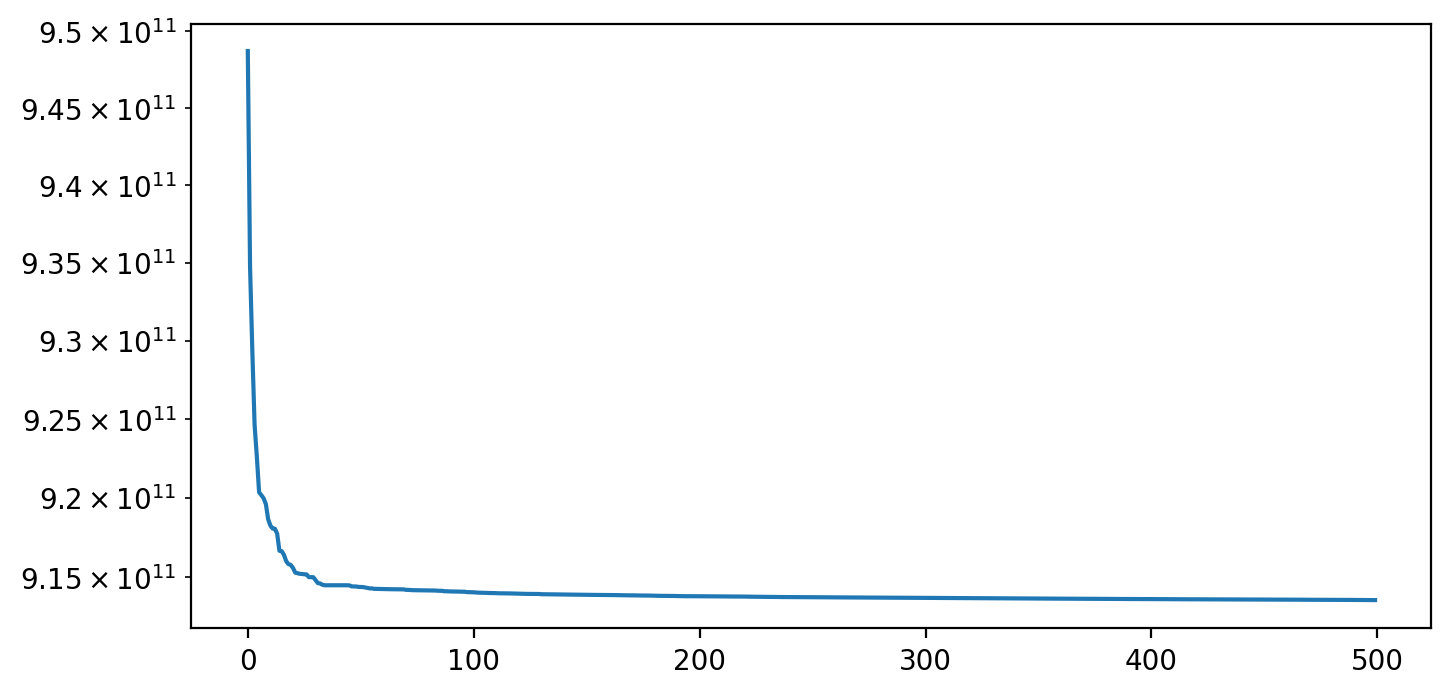

In [774]:
plt.plot(np.arange(len(mleBp.nlls_)), np.sort(mleBp.nlls_)[::-1])
plt.semilogy()

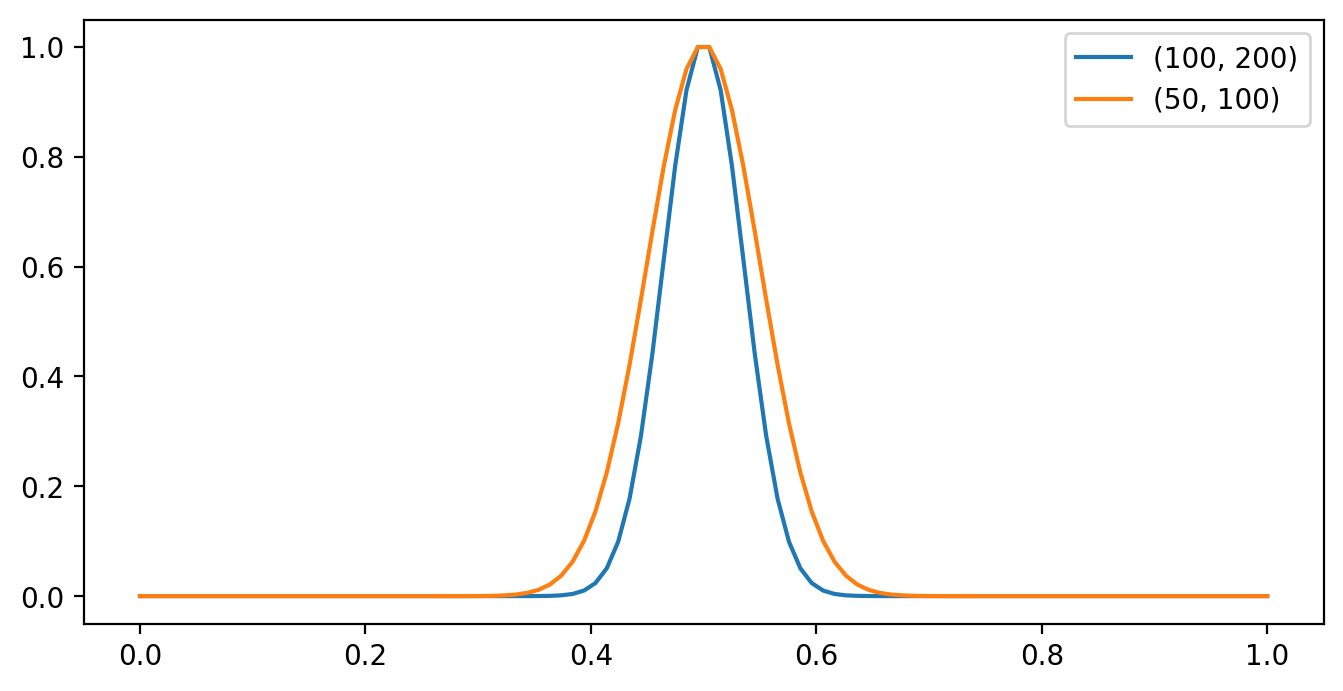

In [784]:
def bl(p, y, n):
    return p**y * (1-p)**(n-y)

p = np.linspace(0, 1, 100)
dats = [(100, 200), (50, 100)]
for dat in dats:
    y, n = dat
    ll = bl(p, y, n)
    plt.plot(p, ll/ll.max(), label=dat)
    
plt.legend()
#plt.semilogy()

In [874]:
mleBp.nlls_.min()

913548038211.7487

ERROR! Session/line number was not unique in database. History logging moved to new session 1759


In [553]:
np.round(mleBp.mle_W, 3)

array([[0.507, 0.917, 0.76 ],
       [0.052, 0.071, 0.065],
       [0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.107],
       [0.439, 0.012, 0.069]])

In [559]:
from bgspy.likelihood import expand_W_simplex

In [562]:
np.round(expand_W_simplex(mleBp.thetas_[np.argsort(mleBp.nlls_)[1]], mleBp.nt, mleBp.nf), 3)

array([[0.523, 0.876, 0.868],
       [0.031, 0.067, 0.083],
       [0.021, 0.   , 0.   ],
       [0.02 , 0.055, 0.   ],
       [0.404, 0.002, 0.048]])

In [564]:
np.round(expand_W_simplex(mleBp.thetas_[np.argsort(mleBp.nlls_)[2]], mleBp.nt, mleBp.nf), 3)

array([[0.501, 0.876, 0.94 ],
       [0.035, 0.064, 0.039],
       [0.028, 0.022, 0.   ],
       [0.   , 0.   , 0.   ],
       [0.436, 0.038, 0.02 ]])

In [540]:
np.round(mleBp.mle_W, 3)

array([[0.642, 0.883, 0.885],
       [0.031, 0.052, 0.063],
       [0.   , 0.   , 0.001],
       [0.012, 0.   , 0.   ],
       [0.315, 0.065, 0.051]])

In [427]:
mleBp.mle_W.sum(axis=0)

array([0.63284013])

In [408]:
913543002497.2695

913543002497.2695

ERROR! Session/line number was not unique in database. History logging moved to new session 1736


In [409]:
mleBp.nll_

914397453781.6565

In [ ]:
mleBp

In [402]:
debug

> /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py(137)fun_wrapped()
    135             # Overwriting results in undefined behaviour because
    136             # fun(self.x) will change self.x, with the two no longer linked.
--> 137             fx = fun(np.copy(x), *args)
    138             # Make sure the function returns a true scalar
    139             if not np.isscalar(fx):



ipdb>  exit


In [18]:
import pickle
pickle.dump({'B': B, 'Bp': Bp, 'Y': Y, 'w': m.w}, open('../data/test_data.pkl', 'wb'))

ERROR! Session/line number was not unique in database. History logging moved to new session 1844


In [25]:
mleBp.to_npz('../data/hg38_test_data.npz')

In [31]:
mleBp.from_npz('../data/hg38_test_data.npz')

MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

In [217]:
from bgspy.likelihood import negll, negll_numba, negll_jax, negll_numba_reparam, logit, inverse_logit

In [53]:
from scipy.optimize import dual_annealing, minimize
from functools import partial

In [136]:
mleB = InterpolatedMLE(m.w, m.t, B, (-5, -1))
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [23]:
import nlopt
from functools import partial
bounds = np.array(mleBp.bounds())

In [103]:
from bgspy.likelihood import negll_numba, negll_jax #negll_numba_reparam, logit, inverse_logit
dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

     fun: 913581543990.2261
 message: ['Maximum number of iteration reached']
    nfev: 74518
    nhev: 0
     nit: 1000
    njev: 2501
  status: 0
 success: True
       x: array([1.85623078e-03, 2.15404094e-08, 1.76376789e-08, 1.54806591e-08,
       9.74644062e-11, 4.53929004e-10, 4.91323533e-10, 1.78693536e-10,
       1.11083109e-10, 9.74644062e-11, 6.87806954e-10, 3.02551005e-10,
       3.56787871e-11, 1.15666406e-09, 4.26532138e-09, 7.96584585e-09])

In [111]:
opt2 = dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

In [113]:
opt2.x[1:].reshape((5,3)) / opt2.x[1:].reshape((5,3)).sum(axis=0)

array([[0.83800999, 0.86939085, 0.76398002],
       [0.01027858, 0.00521702, 0.00948923],
       [0.00493103, 0.00356541, 0.01112151],
       [0.11185774, 0.00780003, 0.0074208 ],
       [0.03492267, 0.11402669, 0.20798844]])

In [110]:
opt.x[1:].reshape((5,3)) / opt.x[1:].reshape((5,3)).sum(axis=0)

array([[0.91037465, 0.77458246, 0.64312564],
       [0.00411919, 0.0199349 , 0.02041145],
       [0.00755223, 0.00487836, 0.00404904],
       [0.02906918, 0.01328694, 0.00148223],
       [0.04888475, 0.18731734, 0.33093163]])

In [252]:
import os
nlls = []
starts = []
thetas = []
success = []
for file in os.listdir('../data/optimization_tests/'):
    d = np.load(os.path.join('../data/optimization_tests/', file))
    nlls.extend(d['nlls'])
    starts.extend(d['starts'])
    thetas.extend(d['thetas'])
    success.extend(d['success'])

d = dict(nlls = np.array(nlls), starts=np.array(starts),
             thetas = np.array(thetas), success = np.array(success))

In [199]:
ot_run = d['thetas'][np.argmin(d['nlls'])][1:].reshape((5, 3))
ot_run / ot_run.sum(axis=0)

array([[8.71149094e-01, 9.63860017e-01, 9.44056133e-01],
       [2.96595472e-04, 1.73864974e-04, 1.83872277e-04],
       [2.96595472e-04, 1.73864974e-04, 1.83872277e-04],
       [2.96595472e-04, 1.73864974e-04, 1.83872277e-04],
       [1.27961120e-01, 3.56183876e-02, 5.53922506e-02]])

Text(0.5, 0, 'ordered index')

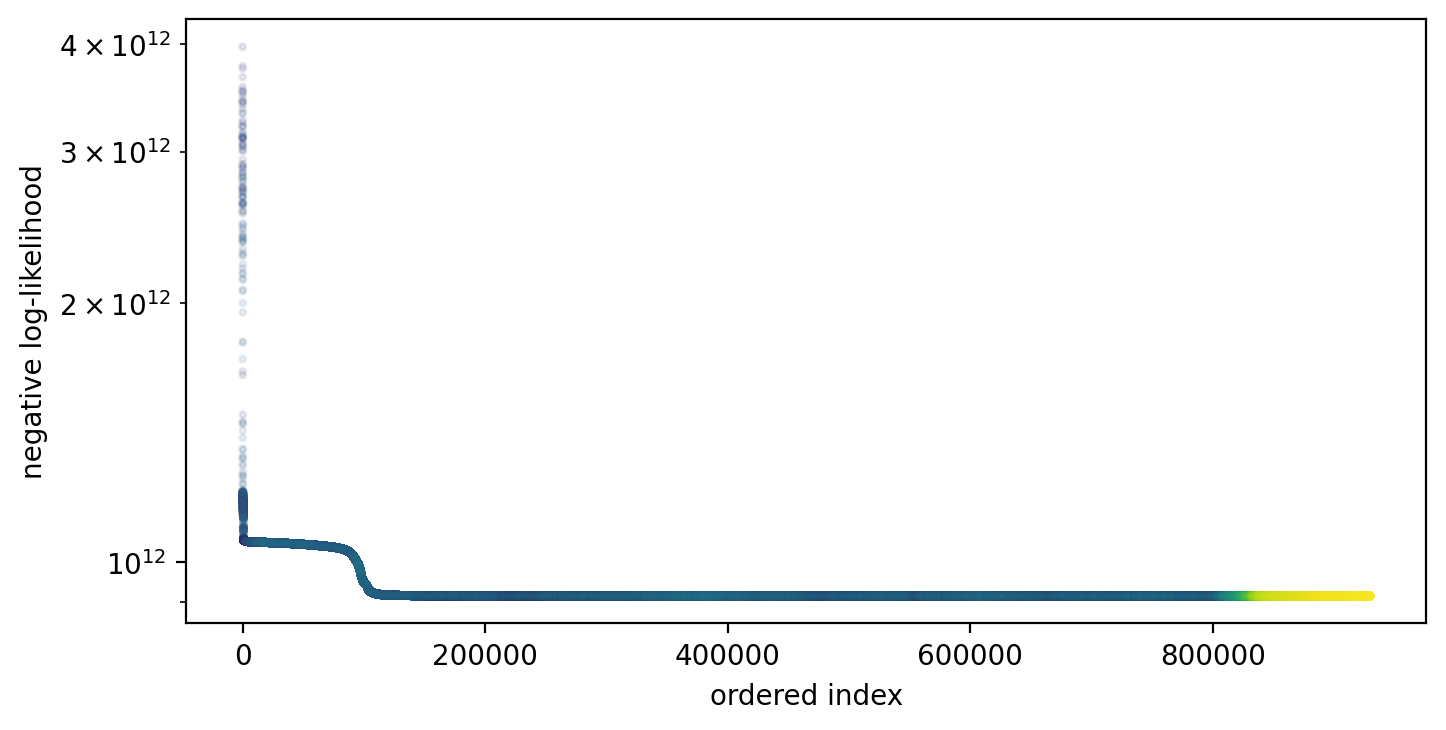

In [248]:
idx = np.argsort(d['nlls'])
x = d['nlls'][idx]
thetas = d['thetas'][idx]
theta_mle = thetas[0, ...]
plt.scatter(np.arange(len(x)), x[::-1], s=5, alpha=0.1, c=np.log(1e-12 + np.sum((thetas - theta_mle)**2, axis=1)))
plt.semilogy()
plt.ylabel('negative log-likelihood')
plt.xlabel('ordered index')

In [253]:
d['success'].mean()

0.9331386468753361

In [213]:
mle0 = d['thetas'][idx[0]]
mle1 = d['thetas'][idx[1]]

In [222]:
from functools import partial
from scipy.optimize import minimize
partial(negll, Y=Y, logB=Bp, w=m.w)(mle0), partial(negll_numba, Y=Y, logB=Bp, w=m.w)(mle1)

(913543002497.2693, 913543353437.276)

In [245]:
nll = partial(negll_numba, Y=Y, logB=Bp, w=m.w)
opt = minimize(nll, mleBp.random_start(), bounds=mleBp.bounds(), method='Nelder-Mead', options=dict(adaptive=True, maxiter=10000))

In [246]:
opt.x[0], np.round(opt.x[1:].reshape((5, 3))/opt.x[1:].reshape((5, 3)).sum(axis=0), 3), x[0], opt.fun

(0.002202941719644072,
 array([[0.86 , 0.868, 0.15 ],
        [0.007, 0.013, 0.11 ],
        [0.   , 0.008, 0.101],
        [0.003, 0.056, 0.375],
        [0.129, 0.054, 0.264]]),
 913543002497.2695,
 914036477462.6555)

In [247]:
x.shape

(10000,)

In [239]:
dir(opt)

['final_simplex', 'fun', 'message', 'nfev', 'nit', 'status', 'success', 'x']

Text(0.5, 0, 'ordered index')

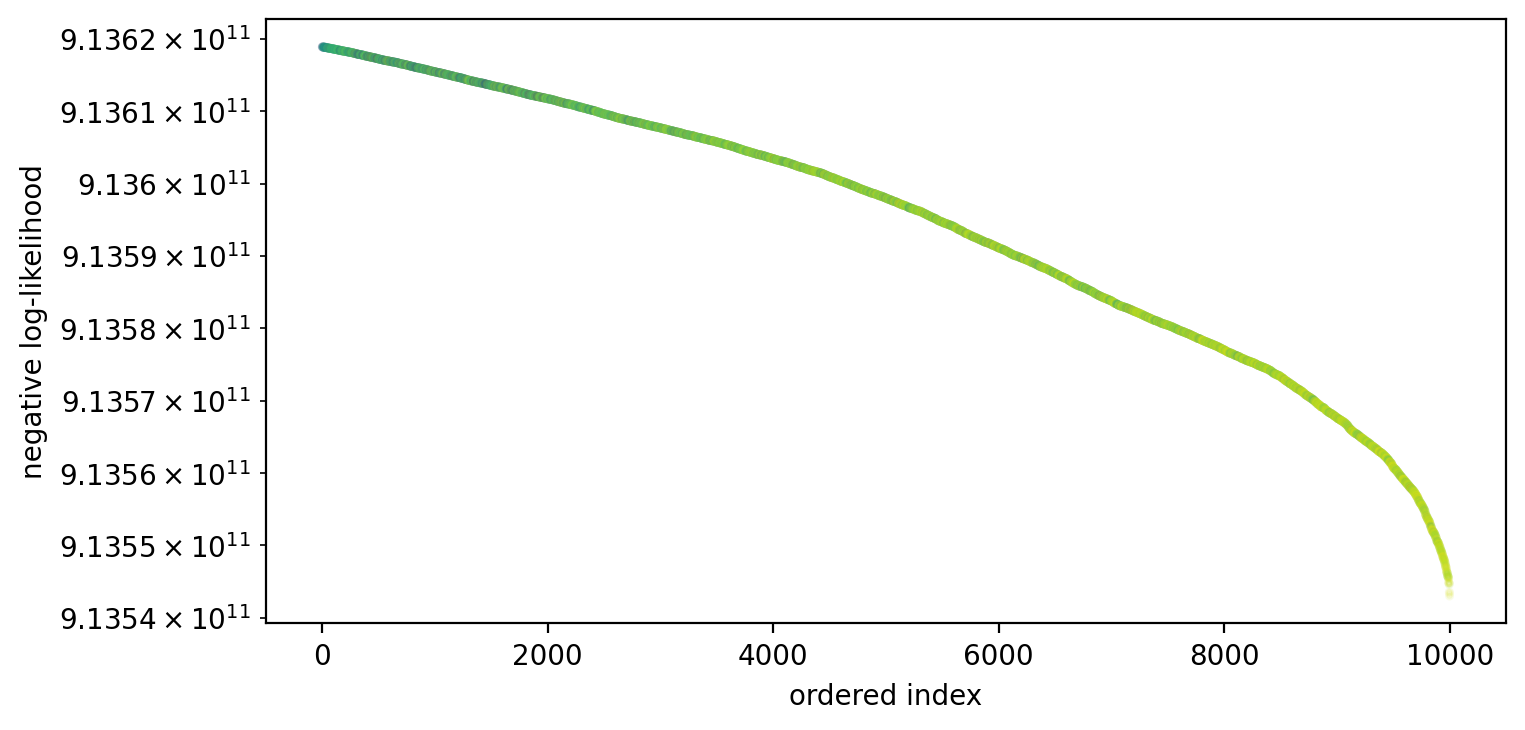

In [201]:
idx = np.argsort(d['nlls'])[:10000]
x = d['nlls'][idx]
thetas = d['thetas'][idx]
theta_mle = thetas[0, ...]
plt.scatter(np.arange(len(x)), x[::-1], s=5, alpha=0.1, c=np.log(1e-12 + np.sum((thetas - theta_mle)**2, axis=1)))
plt.semilogy()
plt.ylabel('negative log-likelihood')
plt.xlabel('ordered index')

In [877]:
np.interp(1e-9, m.w, np.arange(len(m.w)))

2.284747248950801

In [878]:
np.digitize(1e-9, m.w)

3

In [879]:
m.w

array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])

In [886]:
B.strides, B.shape

((720, 120, 24, 8), (2688, 6, 5, 3))

In [892]:
np.arange(6).reshape((3, 2))

array([[0, 1],
       [2, 3],
       [4, 5]])

In [893]:
np.arange(6).reshape((3, 2)).flatten()[0*3 + 1*2]

2

In [883]:
def interp(x, w):
    y = np.arange(len(w))
    for i in range(1, len(w)):
        if w[i-1] <= x and x < w[i]:
            return (y[i] - y[i-1]) / (w[i] - w[i-1]) * (x - w[i-1]) + y[i-1]
interp(1e-9, m.w)

2.284747248950801

In [200]:
np.min(d['nlls'])

913543002497.2695

In [160]:
np.min(d['nlls'])

913543002497.2695

In [154]:
np.min(d['nlls'])

913545467948.7026

In [118]:
np.sum((thetas - np.repeat(0, thetas.shape[1]))**2, axis=1)

array([3.61131359e-06, 3.76932432e-06, 3.64997925e-06, ...,
       9.99873708e-03, 9.99912540e-03, 9.99833980e-03])

In [202]:
xx = d['thetas'][np.argsort(d['nlls'])[0]][1:].reshape((5, 3))
np.round(xx / xx.sum(axis=0), 3), xx

(array([[0.871, 0.964, 0.944],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.128, 0.036, 0.055]]),
 array([[2.93716248e-08, 5.54372740e-08, 5.13430382e-08],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [4.31433153e-09, 2.04862353e-09, 3.01253955e-09]]))

In [203]:
xx = d['thetas'][np.argsort(d['nlls'])[1]][1:].reshape((5, 3))
np.round(xx / xx.sum(axis=0), 3)

array([[0.781, 0.93 , 0.957],
       [0.004, 0.006, 0.006],
       [0.008, 0.001, 0.005],
       [0.01 , 0.007, 0.006],
       [0.197, 0.057, 0.026]])

In [204]:
xx = d['thetas'][np.argsort(d['nlls'])[2]][1:].reshape((5, 3))
np.round(xx / xx.sum(axis=0), 3)

array([[0.849, 0.918, 0.942],
       [0.003, 0.003, 0.005],
       [0.005, 0.006, 0.003],
       [0.002, 0.002, 0.005],
       [0.142, 0.072, 0.044]])

In [177]:
xx.sum(axis=0)

array([1.49234755e-08, 1.58508453e-08, 1.85685562e-08])

In [151]:
xx = d['thetas'][np.argsort(d['nlls'])[1]][1:].reshape((5, 3))
np.round(xx / xx.sum(axis=0), 3)

array([[0.852, 0.994, 0.941],
       [0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.147, 0.006, 0.059]])

In [152]:
xx = d['thetas'][np.argsort(d['nlls'])[2]][1:].reshape((5, 3))
np.round(xx / xx.sum(axis=0), 3)

array([[0.808, 0.923, 0.915],
       [0.003, 0.01 , 0.013],
       [0.011, 0.009, 0.006],
       [0.002, 0.002, 0.017],
       [0.175, 0.056, 0.05 ]])

In [170]:
np.diff(d['nlls'][np.argsort(d['nlls'])])

array([3.50940006e+05, 2.07830003e+05, 1.04884175e+06, ...,
       7.86642785e+09, 9.94121554e+09, 2.36932031e+11])

In [61]:
x[0]

913573126158.966

In [254]:
from scipy.optimize import basinhopping, direct

ImportError: cannot import name 'direct' from 'scipy.optimize' (/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/__init__.py)

In [259]:
from bgspy.likelihood import BGSMLE
mleBp = BGSMLE(m.w, m.t, Bp, (-5, -1))
mleBp.to_npz('../data/human_fitdata.npz')

[autoreload of bgspy.likelihood failed: Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/vsb/projects/bprime/bgspy/likelihood.py", line 327
    np.savez(filename, logB=self.logB, w=

ImportError: cannot import name 'BGSMLE' from 'bgspy.likelihood' (/home/vsb/projects/bprime/bgspy/likelihood.py)

## Bayes Experiments

In [394]:
mleBp.to_json('../stan_experiments/bgs.json')

In [272]:
import json
np.array(json.load(open('../stan_experiments/bgs.json'))['Y'])

array([[10293792075,    15437413],
       [37699898419,    66093582],
       [36266333412,    50201707],
       ...,
       [42185195361,    94428377],
       [33513056681,    67565736],
       [34090806907,    52997739]])

In [797]:
d = pd.read_csv(f'../stan_experiments/output_1.csv', comment='#', usecols=cols)

In [819]:
cols = ['lp__', 'divergent__', 'pi0'] + ['W.1.1', 'W.2.1','W.3.1','W.1.2','W.2.2','W.3.2','W.1.3',
                                          'W.2.3','W.3.3', 'W.1.4', 'W.2.4', 'W.3.4', 'W.1.5', 'W.2.5', 'W.3.5']

ds = []
for i in [1, 2, 3, 4, 5, 6]:
    d = pd.read_csv(f'../stan_experiments/output_{i}.csv', usecols=cols, comment='#')
    d['chain'] = i
    d['iter'] = np.arange(d.shape[0])
    ds.append(d.loc[d['iter'] > 80_000, :])
d = pd.concat(ds)

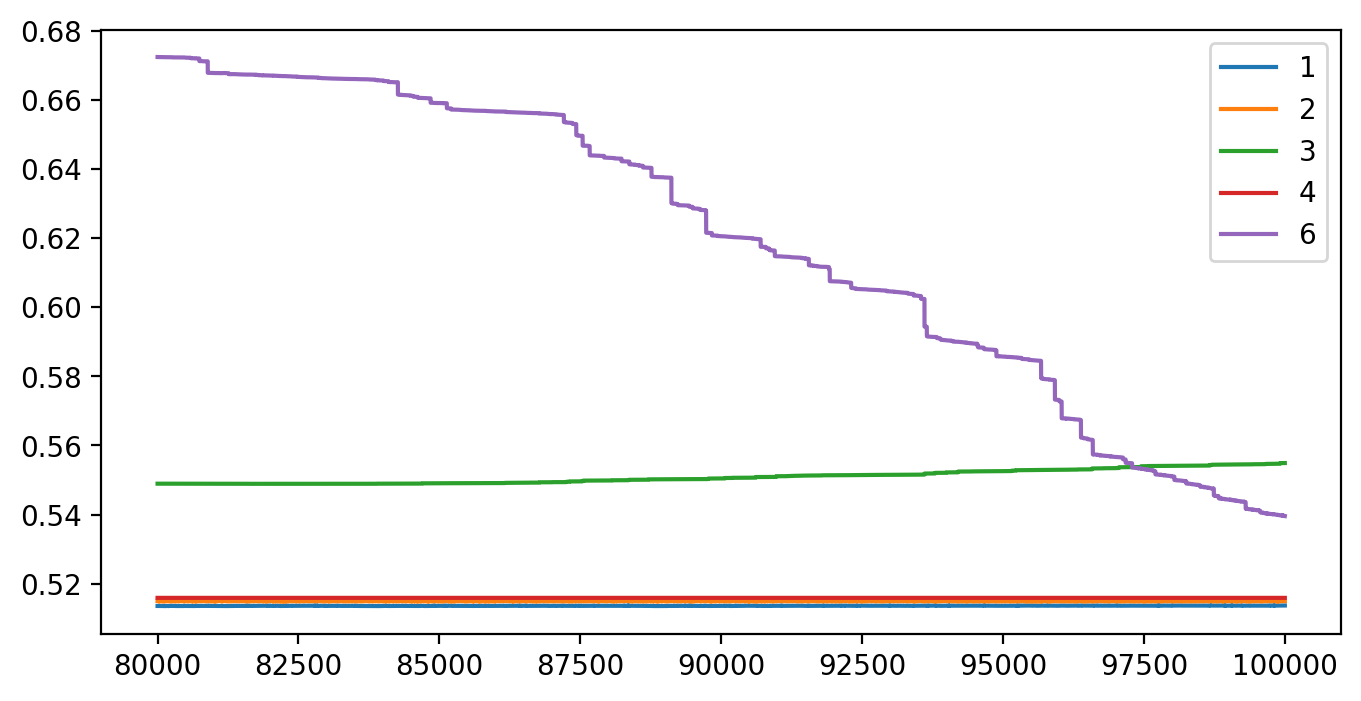

In [858]:
for i in d['chain'].unique():
    dx = d.loc[d['chain'] == i, :]
    plt.plot(dx['iter'], dx['W.1.1'], label=i)
plt.legend()
#plt.ylim(1.92e-3, 1.935e-3)

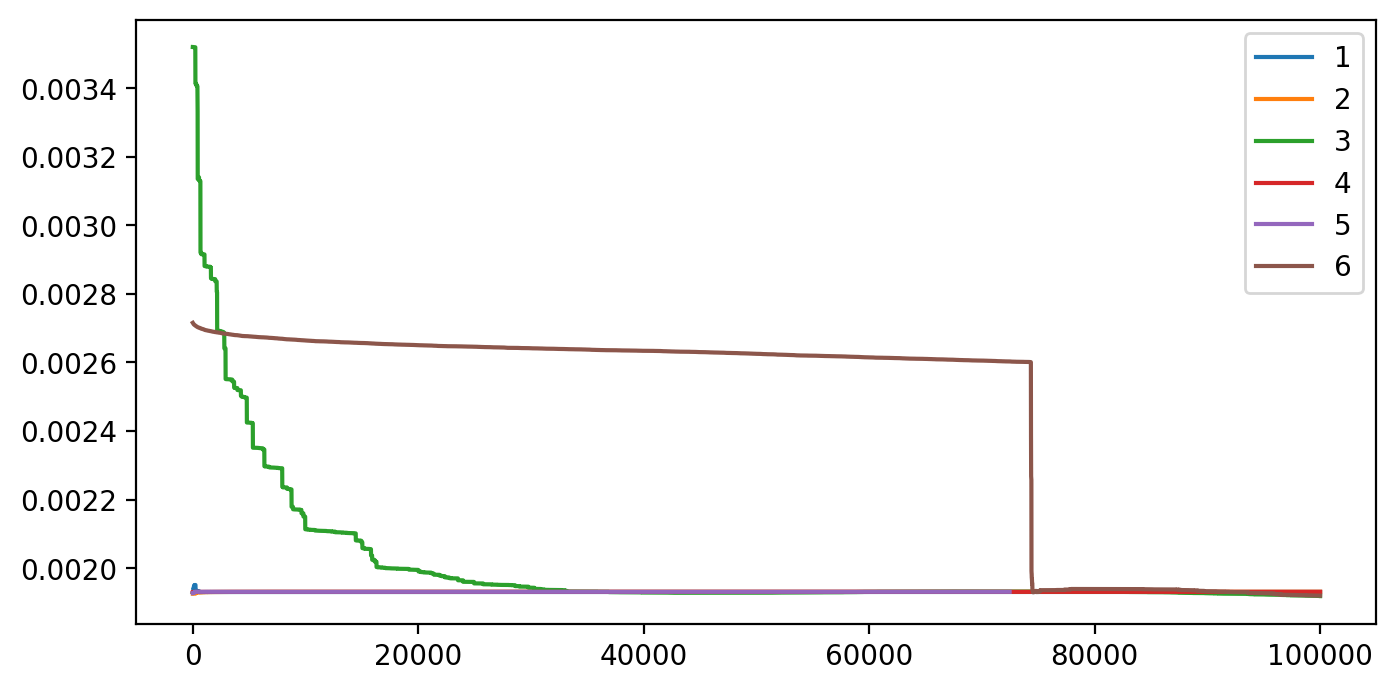

In [804]:
for i in d['chain'].unique():
    dx = d.loc[d['chain'] == i, :]
    plt.plot(dx['iter'], dx['pi0'], label=i)
plt.legend()
#plt.ylim(1.92e-3, 1.935e-3)

In [839]:
dx = d.iloc[1000:, :]
x = dx['W.1.1'].values
y = dx['W.1.5'].values 
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
kernel = stats.gaussian_kde(np.vstack((x, y)))
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kernel(positions).T, xx.shape)

<a list of 0 text.Text objects>

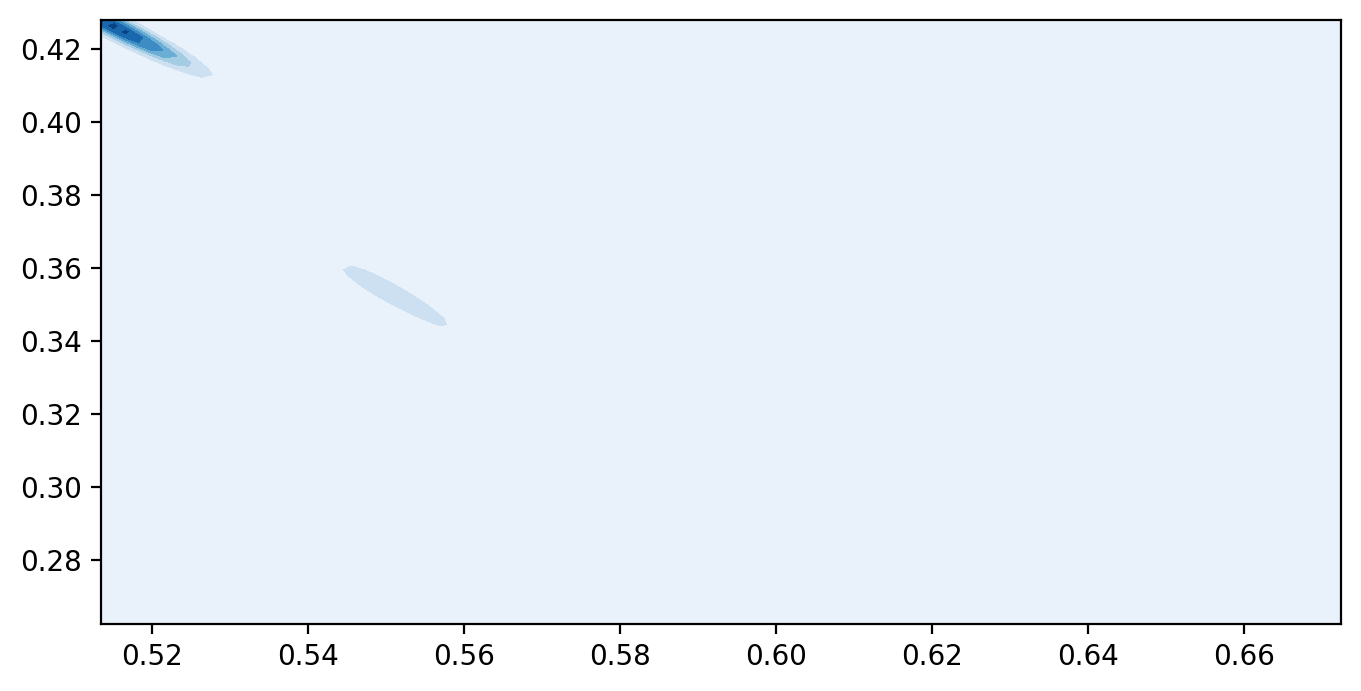

In [840]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
#cset = ax.contour(xx, yy, f, colors='k', linewidth=0.1)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)

In [841]:
d.columns.tolist()

['lp__',
 'divergent__',
 'pi0',
 'W.1.1',
 'W.2.1',
 'W.3.1',
 'W.1.2',
 'W.2.2',
 'W.3.2',
 'W.1.3',
 'W.2.3',
 'W.3.3',
 'W.1.4',
 'W.2.4',
 'W.3.4',
 'W.1.5',
 'W.2.5',
 'W.3.5',
 'chain',
 'iter']

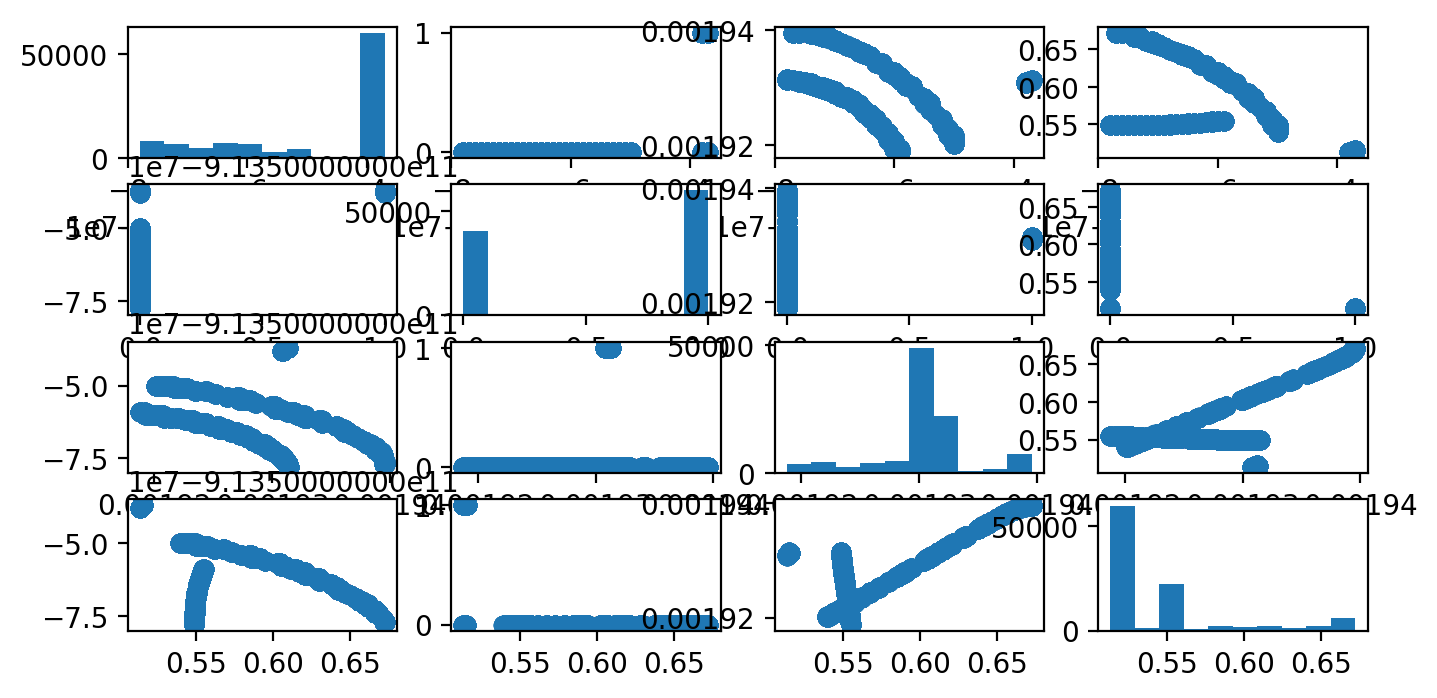

In [855]:
import itertools
def pairs(d, cols=None):
    if cols is None:
        cols = d.columns.tolist()
    i = list(range(len(cols)))
    combs = list(itertools.product(i, i))
    fig, ax = plt.subplots(ncols=len(cols), nrows=len(cols))
    for (col_i, col_j) in combs:
        x = d.iloc[:, col_i]
        if col_i == col_j:
            ax[col_i, col_j].hist(x)
            continue
        x = d.iloc[:, col_i]
        y = d.iloc[:, col_j]
        ax[col_i, col_j].scatter(x, y)
    #plt.tight_layout()
pairs(d, cols=('pi0', 'W.1.1', 'W.1.2', 'W.1.3'))

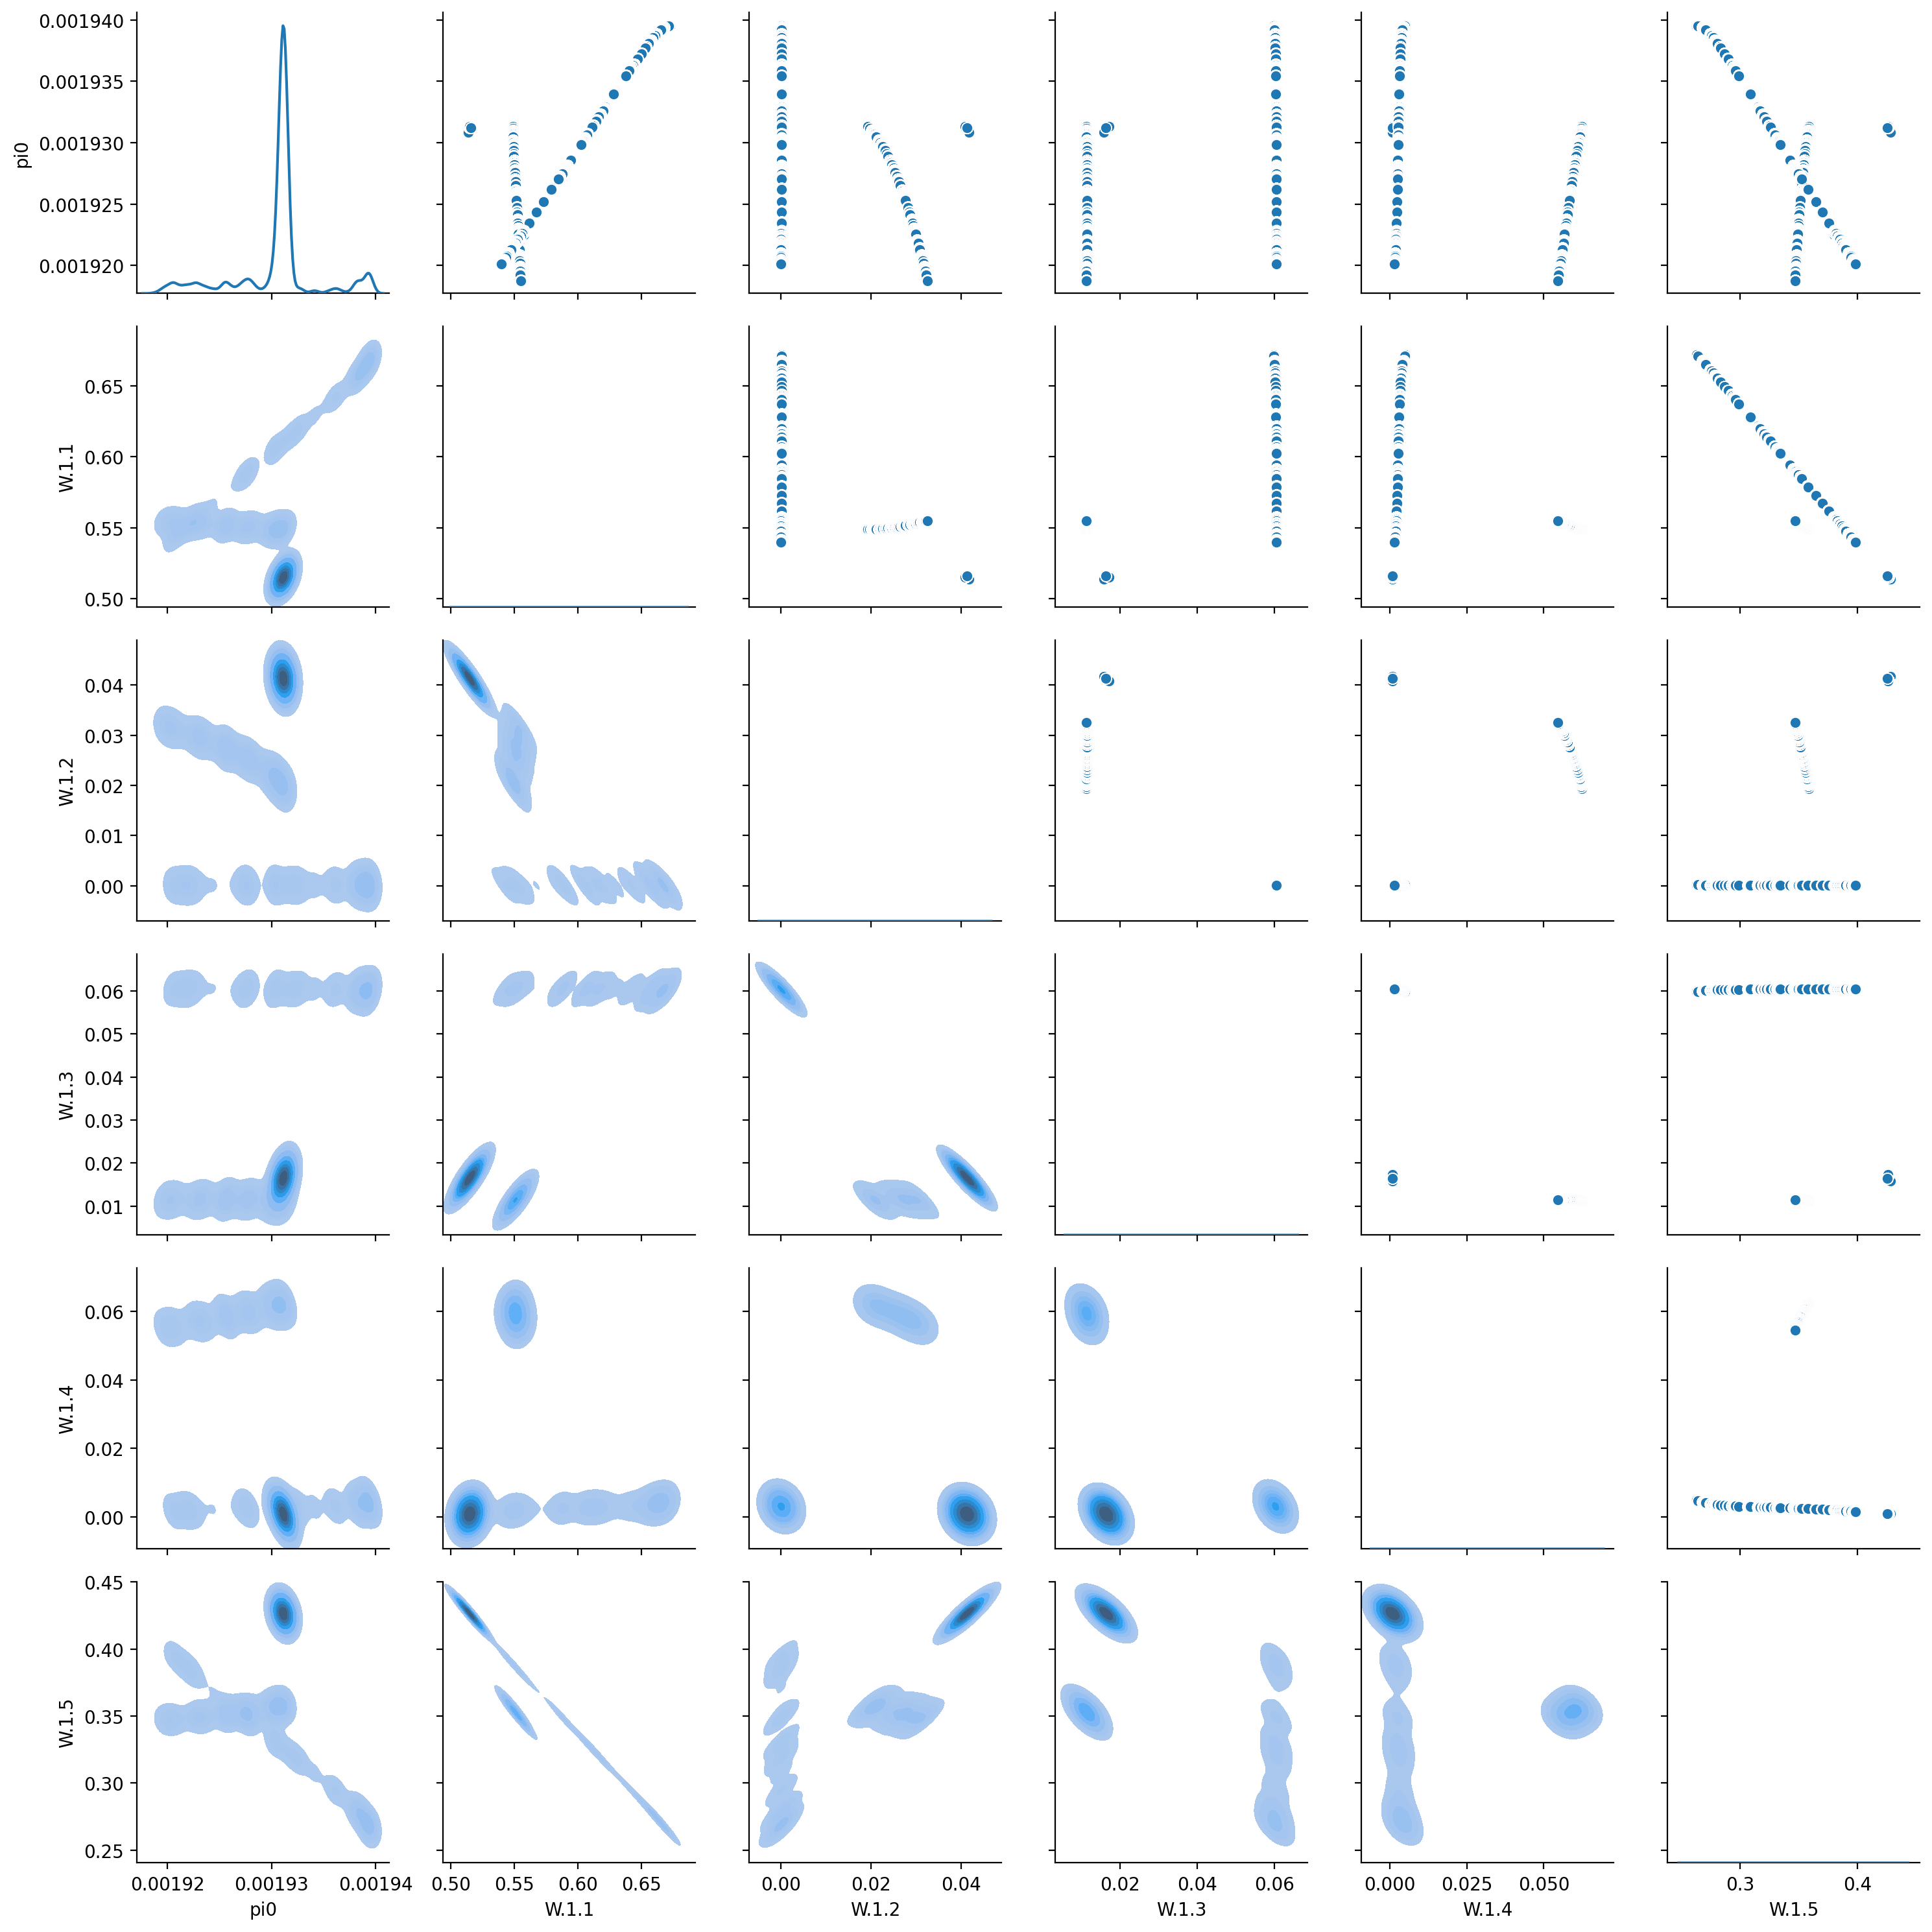

In [857]:
gg = sns.PairGrid(d.loc[:, ('pi0', 'W.1.1', 'W.1.2', 'W.1.3', 'W.1.4', 'W.1.5')].reset_index(drop=True))
gg.map_upper(sns.scatterplot)
gg.map_lower(sns.kdeplot, fill=True)
gg.map_diag(sns.kdeplot)
plt.tight_layout()

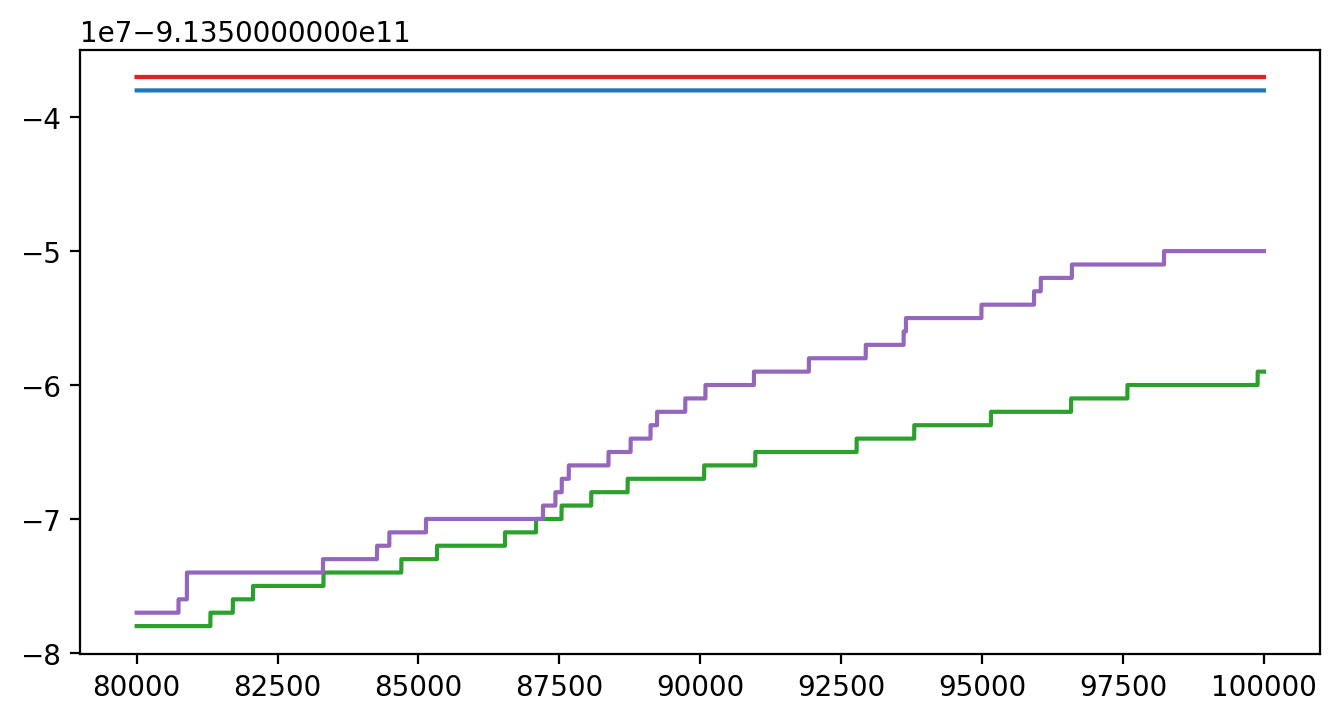

In [861]:
for chain in d.chain.unique():
    dc = d.loc[d['chain'] == chain, :]
    plt.plot(dc.iter, dc.lp__)

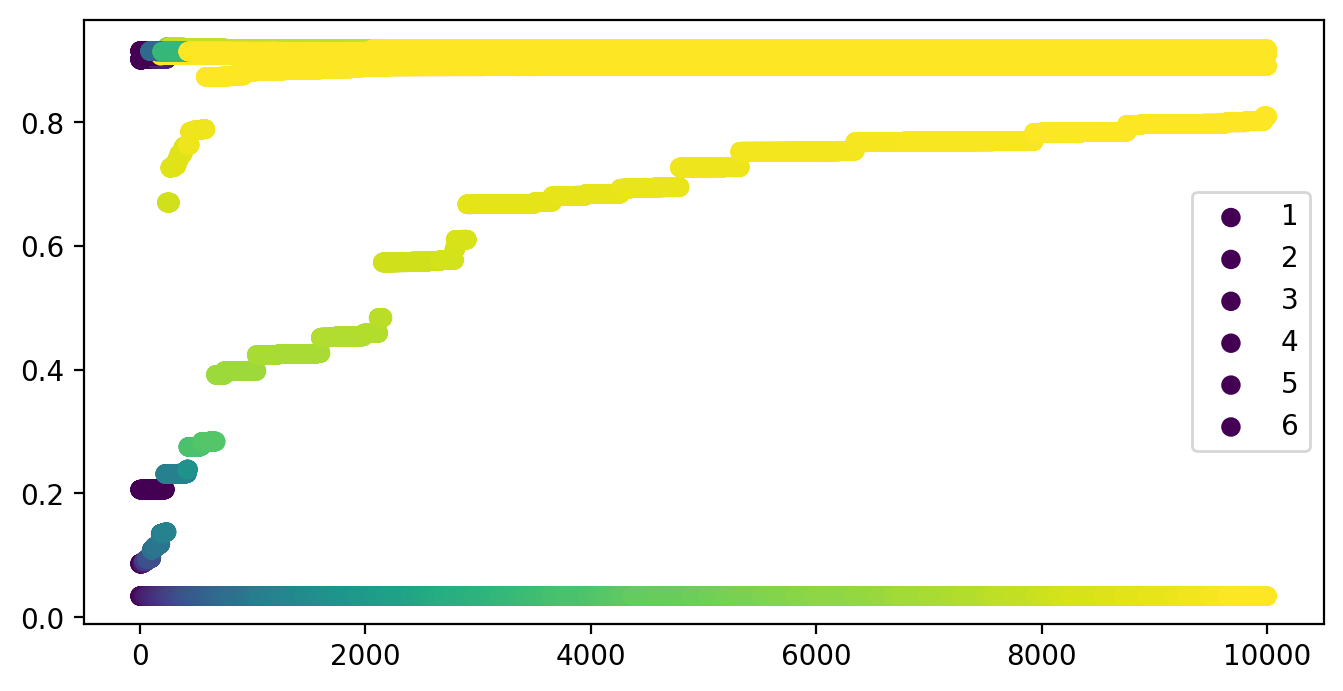

In [729]:
for i in d['chain'].unique():
    dx = d.loc[d['chain'] == i, :]
    plt.scatter(dx['iter'], dx['W.2.1'], label=i, c=dx['lp__'])
plt.legend()

In [734]:
d.loc[d['lp__'] == d['lp__'].max(), :]

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pi0,W.1.1,W.2.1,...,logB.2476,logB.2477,logB.2478,logB.2479,logB.2480,logB.2481,logB.2482,Wkj,chain,iter
2061,-9.135370e+11,0.895989,0.000642,3,15,1,9.135380e+11,0.001931,0.509831,0.917570,...,-0.190559,-0.219922,-0.203543,-0.134113,-0.111856,-0.105459,-0.143964,2.549710e-09,2,2061
2062,-9.135370e+11,0.940904,0.000642,4,18,1,9.135370e+11,0.001931,0.509846,0.917570,...,-0.190554,-0.219920,-0.203539,-0.134108,-0.111853,-0.105457,-0.143962,2.549590e-09,2,2062
2063,-9.135370e+11,0.729762,0.000642,2,6,1,9.135370e+11,0.001931,0.509853,0.917571,...,-0.190552,-0.219914,-0.203536,-0.134108,-0.111852,-0.105456,-0.143958,2.550010e-09,2,2063
2064,-9.135370e+11,0.939131,0.000642,3,7,0,9.135370e+11,0.001931,0.509849,0.917571,...,-0.190554,-0.219921,-0.203537,-0.134108,-0.111853,-0.105457,-0.143960,2.549690e-09,2,2064
2065,-9.135370e+11,0.993695,0.000642,4,15,0,9.135370e+11,0.001931,0.509848,0.917570,...,-0.190556,-0.219917,-0.203535,-0.134110,-0.111854,-0.105458,-0.143957,2.550260e-09,2,2065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-9.135370e+11,0.888889,0.000066,3,9,1,9.135370e+11,0.001931,0.515358,0.914644,...,-0.189943,-0.219108,-0.203231,-0.133679,-0.111471,-0.105134,-0.143864,2.986820e-09,5,9995
9996,-9.135370e+11,0.764462,0.000066,2,5,1,9.135370e+11,0.001931,0.515354,0.914643,...,-0.189944,-0.219107,-0.203230,-0.133680,-0.111472,-0.105135,-0.143863,2.986590e-09,5,9996
9997,-9.135370e+11,0.641469,0.000066,3,8,1,9.135370e+11,0.001931,0.515357,0.914639,...,-0.189942,-0.219108,-0.203232,-0.133679,-0.111470,-0.105134,-0.143866,2.986490e-09,5,9997
9998,-9.135370e+11,0.890375,0.000066,6,116,1,9.135370e+11,0.001931,0.515383,0.914649,...,-0.189936,-0.219098,-0.203213,-0.133673,-0.111466,-0.105130,-0.143849,2.986350e-09,5,9998


In [ ]:
sns.plot('ds

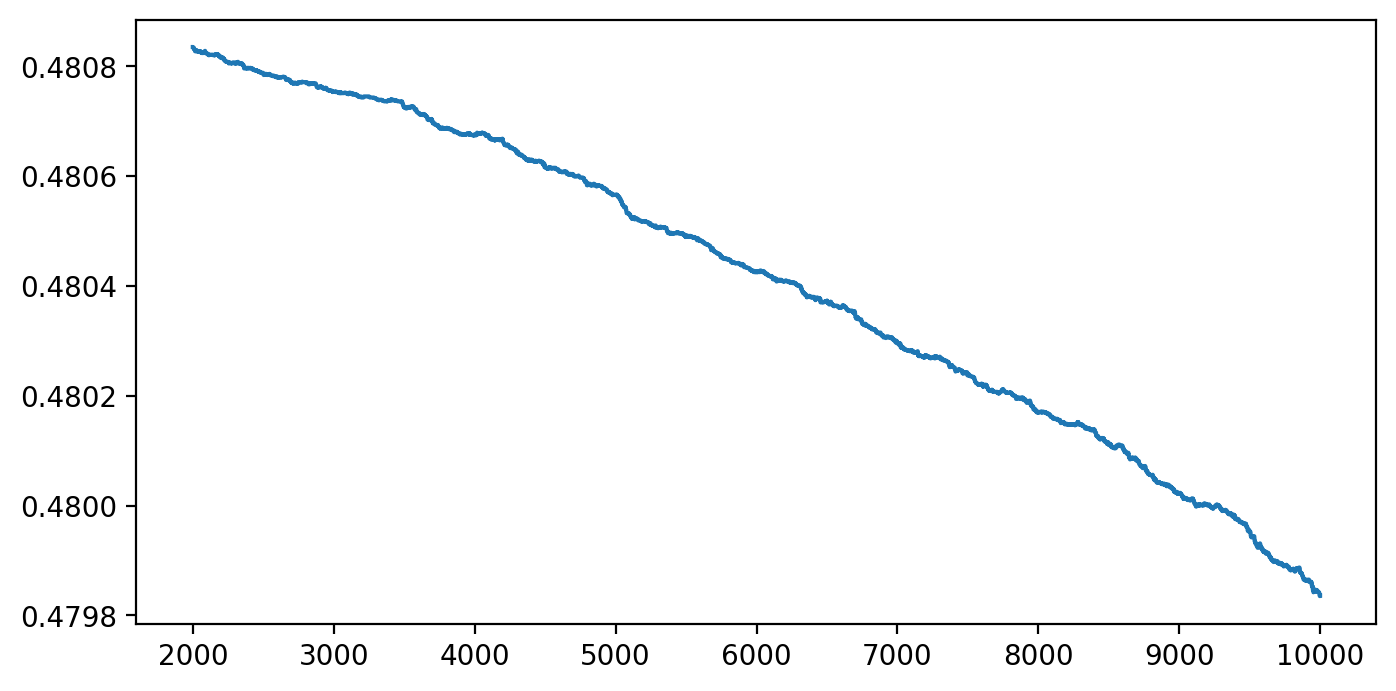

In [689]:
W = d.loc[:, [x.startswith('W.') for x in d.columns.tolist()]]
burnin = 2000
plt.plot(d.loc[burnin:, 'W.1.1'])

In [632]:
W.values[map_idx, ...]

array([5.14943e-01, 9.16954e-01, 6.42354e-01, 4.08354e-02, 8.25133e-02,
       8.42787e-02, 1.72750e-02, 5.17782e-05, 8.55290e-04, 9.07389e-04,
       3.49801e-04, 8.75473e-04, 4.26039e-01, 1.30836e-04, 2.71636e-01])

In [633]:
map_idx = np.argmax(d['lp__'].values)
np.round(W.values[map_idx, ...].reshape((5, 3)), 4)

array([[5.149e-01, 9.170e-01, 6.424e-01],
       [4.080e-02, 8.250e-02, 8.430e-02],
       [1.730e-02, 1.000e-04, 9.000e-04],
       [9.000e-04, 3.000e-04, 9.000e-04],
       [4.260e-01, 1.000e-04, 2.716e-01]])

In [634]:
np.round(W.values.mean(axis=0).reshape((5, 3)), 3)

array([[0.515, 0.917, 0.642],
       [0.041, 0.083, 0.084],
       [0.017, 0.   , 0.001],
       [0.001, 0.   , 0.001],
       [0.426, 0.   , 0.272]])

In [749]:
#cols = [x for x in d.columns.tolist() if (x.startswith('W.') or x in ('divergent__', 'pi0', 'mu'))][:6]
cols = [x for x in d.columns.tolist() if (x.startswith('W.') or x in ('pi0', 'mu'))][:6]
params = d.loc[:, cols]

In [750]:
params

,pi0,W.1.1,W.2.1,W.3.1,W.1.2,W.2.2
0,0.001928,0.702380,0.086649,0.738416,0.032578,0.030492
1,0.001928,0.702367,0.086651,0.738415,0.032585,0.030495
2,0.001928,0.702119,0.086690,0.738435,0.032691,0.030541
3,0.001928,0.702103,0.086692,0.738434,0.032699,0.030544
4,0.001928,0.702087,0.086694,0.738438,0.032706,0.030547
...,...,...,...,...,...,...
9995,0.002664,0.129747,0.034238,0.681069,0.001224,0.084582
9996,0.002664,0.129747,0.034238,0.681069,0.001224,0.084582
9997,0.002664,0.129747,0.034238,0.681069,0.001224,0.084582
9998,0.002664,0.129747,0.034238,0.681069,0.001224,0.084582


In [741]:
d['divergent__'].sum() / d['divergent__'].shape[0]

0.927

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

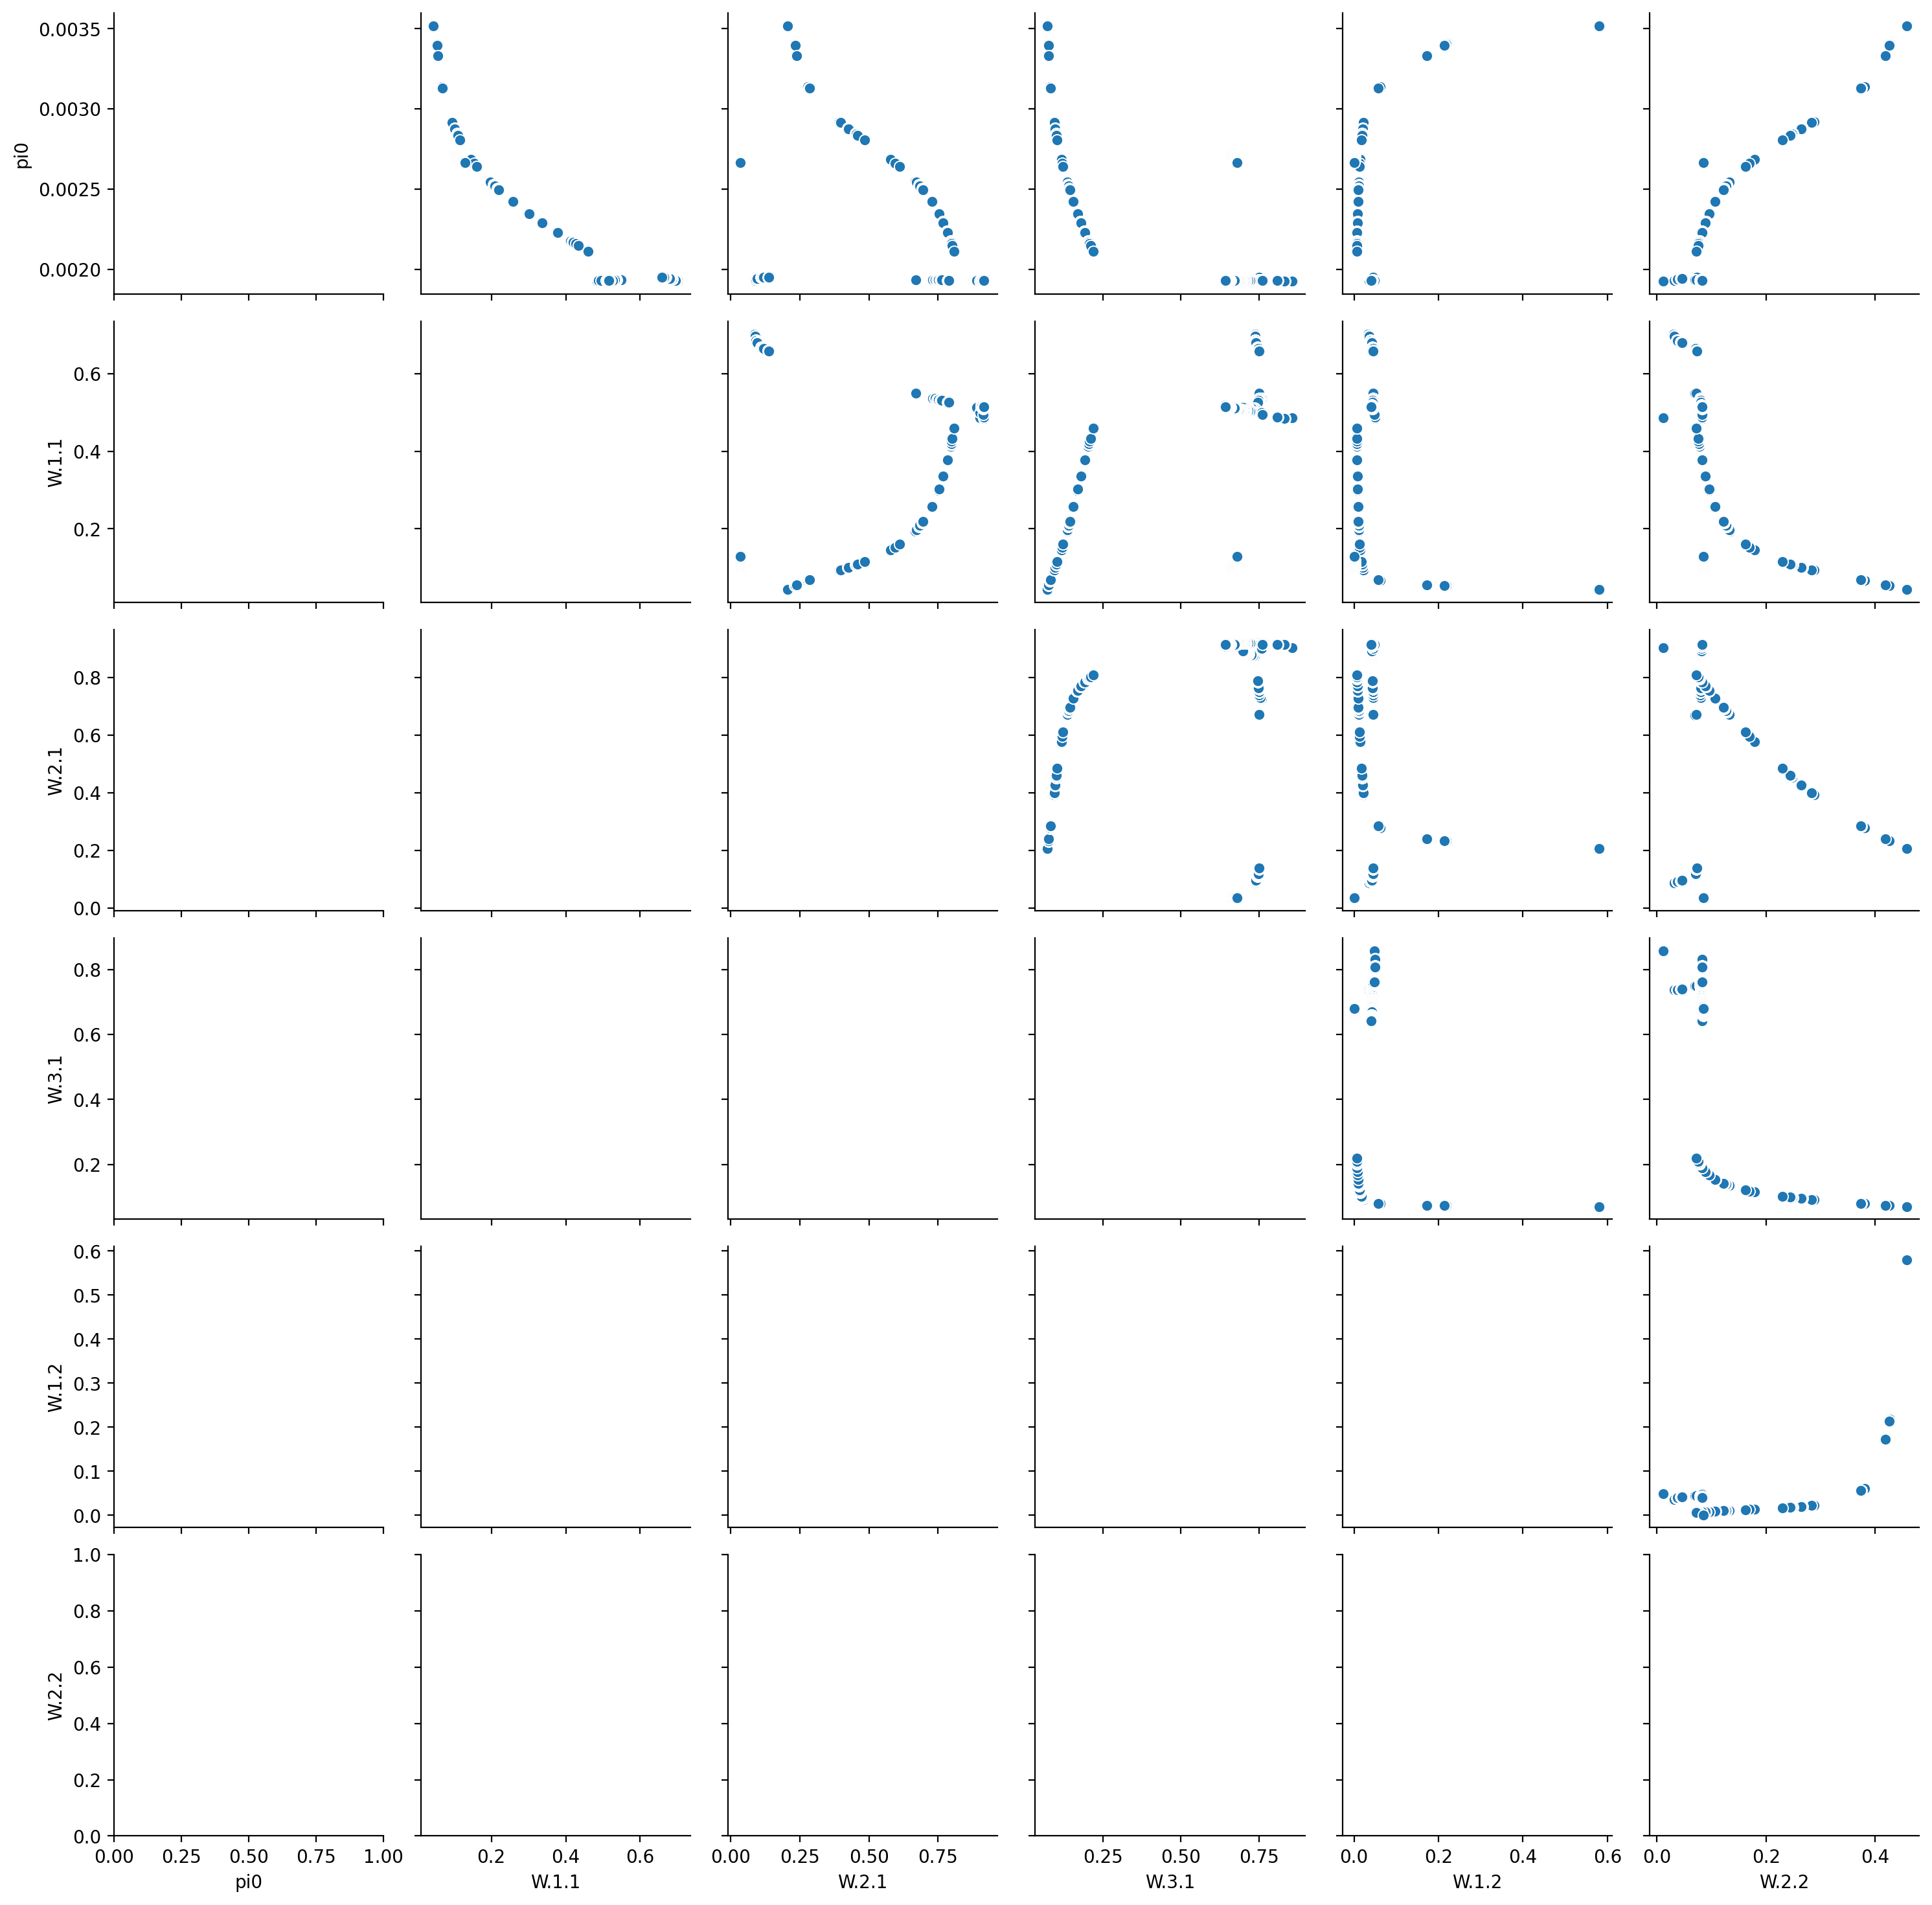

In [751]:
import seaborn as sns
#gg = sns.PairGrid(params, hue="divergent__")
#gg = sns.PairGrid(params.iloc[burnin:, :], hue="divergent__")
burnin = 0
gg = sns.PairGrid(params.iloc[burnin:, :])
gg.map_upper(sns.scatterplot)
gg.map_lower(sns.kdeplot)
gg.map_diag(sns.kdeplot)
plt.tight_layout()

(array([123., 110.,  83., 146., 248.,  49.,  85., 110.,  31.,  15.]),
 array([0.00038343, 0.00039545, 0.00040747, 0.00041949, 0.00043151,
        0.00044353, 0.00045555, 0.00046757, 0.0004796 , 0.00049162,
        0.00050364]),
 <BarContainer object of 10 artists>)

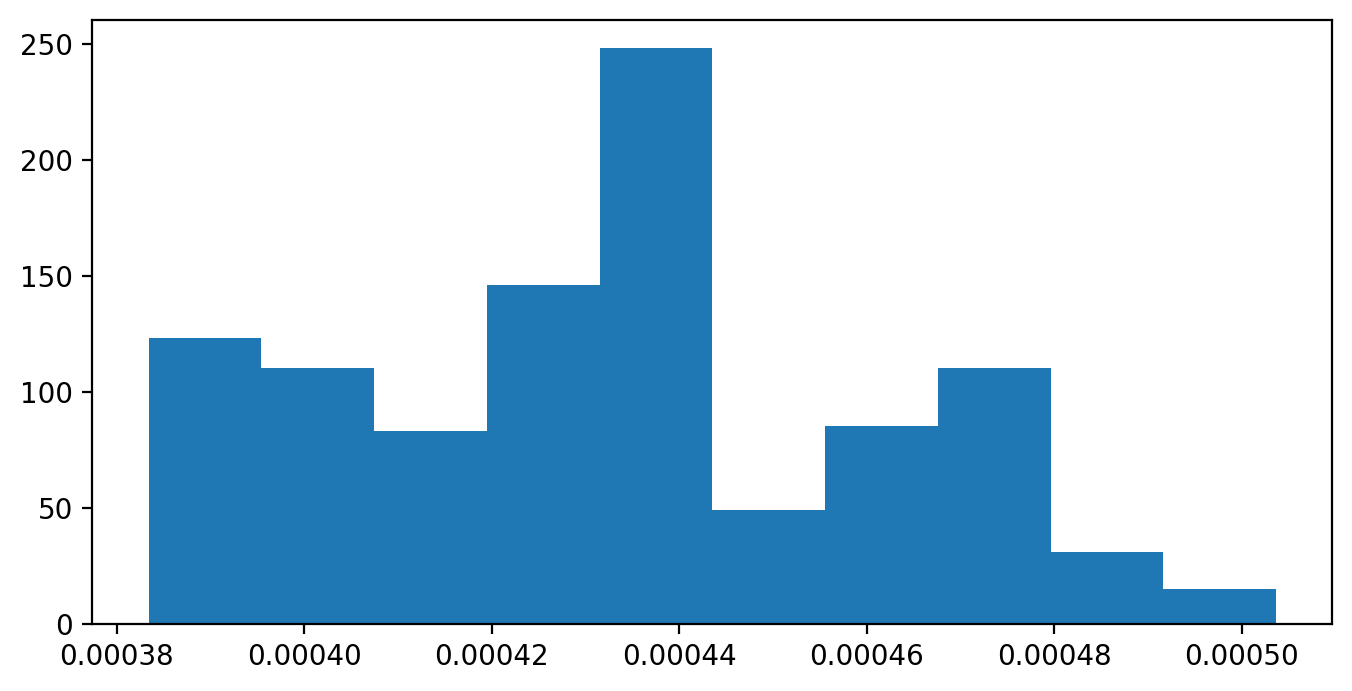

In [601]:
plt.hist(d['W.1.4'])

(array([995.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   3.]),
 array([-7.81362009, -7.81300022, -7.81238035, -7.81176048, -7.81114062,
        -7.81052075, -7.80990088, -7.80928101, -7.80866114, -7.80804127,
        -7.8074214 ]),
 <BarContainer object of 10 artists>)

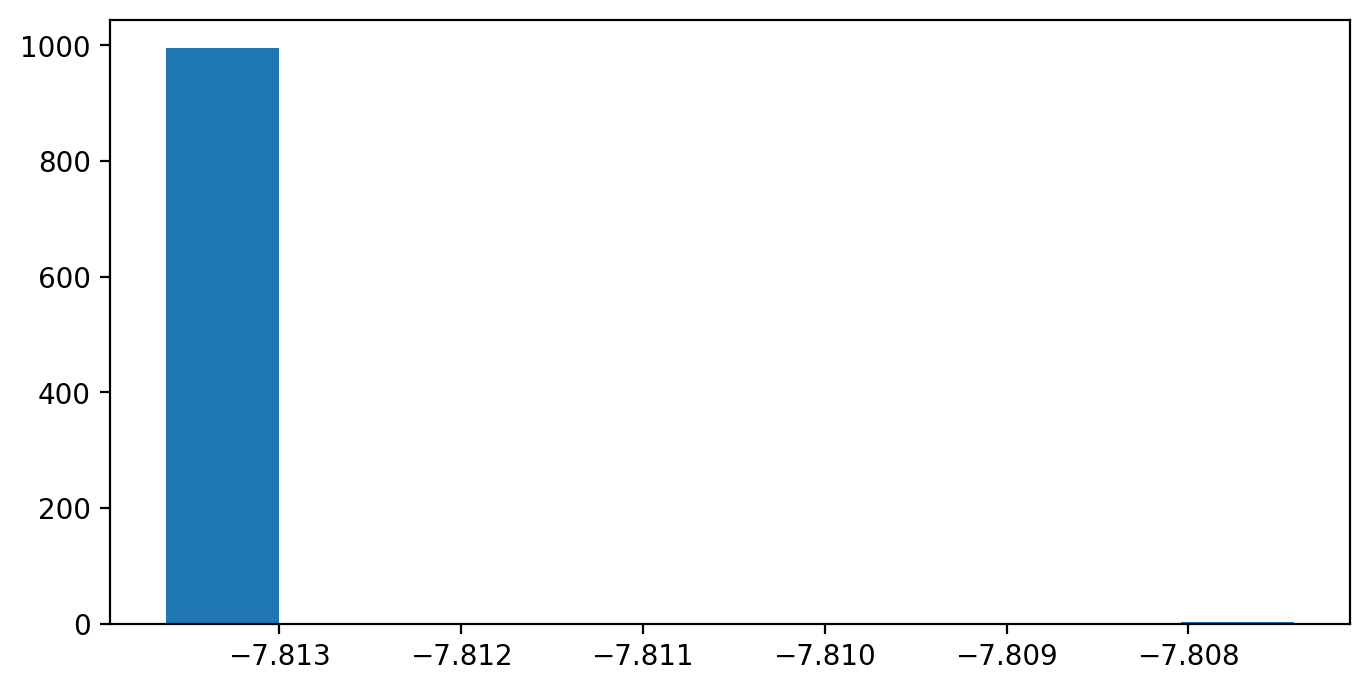

In [286]:
plt.hist(np.log10(d['mu']))

In [277]:
xp = np.array([1e-11,6.30957e-11,3.98107e-10,2.51189e-09,1.58489e-08,1e-07])
yp = np.array([-4.07553e-05,-0.000257149,-0.0016225,-0.0102373,-0.0645928,-0.407553])
x = 5.85689e-08

np.abs(xp-x), np.argmin(np.abs(xp-x))

(array([5.85589000e-08, 5.85058043e-08, 5.81707930e-08, 5.60570100e-08,
        4.27200000e-08, 4.14311000e-08]),
 5)

In [250]:
class MyBounds:
    def __init__(self, xmin, xmax):
        self.xmin = np.array(xmin)
        self.xmax = np.array(xmax)
    def __call__(self, **kwargs):
        x = kwargs["x_new"].flatten()
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        accept = (tmax and tmin)
        return accept

In [251]:
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [252]:
bh = basinhopping(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.random_start(), niter=1000, accept_test=MyBounds(*mleBp.bounds(paired=False)))

In [273]:
np.exp(-6.872827361803502e-05)

0.9999312740881157

In [101]:
np.round(inverse_logit(opt.x), 5)

array([0.0118, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 2.0574, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [99]:
np.round(inverse_logit(opt.x), 5)

array([0.0118, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 2.0574, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [78]:
start = mleBp.random_start()
start, inverse_logit(logit(start))

(array([[1.96788018e-02],
        [1.15410244e-08],
        [4.98654578e-08],
        [3.79276924e-08],
        [8.54618007e-08],
        [2.52703357e-08],
        [4.54989090e-08],
        [3.31008840e-08],
        [2.58978536e-09],
        [2.29748500e-08],
        [1.16931251e-08],
        [6.46119064e-08],
        [7.01185330e-08],
        [4.42712796e-08],
        [9.68091759e-08],
        [8.76177665e-08]]),
 array([[5.39868456e-03],
        [3.10385955e-09],
        [1.34108878e-08],
        [1.02003279e-08],
        [2.29842201e-08],
        [6.79624017e-09],
        [1.22365418e-08],
        [8.90219908e-09],
        [6.96500558e-10],
        [6.17888897e-09],
        [3.14476573e-09],
        [1.73768191e-08],
        [1.88577793e-08],
        [1.19063814e-08],
        [2.60359999e-08],
        [2.35640487e-08]]))

In [71]:
logit(inverse_logit(10))

FloatingPointError: invalid value encountered in log

In [41]:
opt = nlopt.opt(nlopt.LN_COBYLA, bounds.shape[0])
opt.set_lower_bounds(bounds[:, 0])
opt.set_upper_bounds(bounds[:, 1])
opt.set_ftol_rel(1e-6)
opt.set_min_objective(partial(negll_numba, Y=Y, logB=Bp, w=m.w))
    

In [42]:
xmin = opt.optimize(mleBp.random_start().squeeze())


TypeError: too many arguments: expected 4, got 5

In [37]:
mleBp.random_start()

array([[4.20047694e-02],
       [3.04137848e-08],
       [5.07455134e-08],
       [4.19268564e-08],
       [6.51920269e-08],
       [7.87128869e-08],
       [8.71187843e-08],
       [4.50425356e-08],
       [1.31658231e-09],
       [9.97755719e-08],
       [3.98180223e-08],
       [4.16922842e-08],
       [8.44181638e-08],
       [8.36453482e-08],
       [3.13555809e-08],
       [6.89475442e-08]])

In [21]:
opt = dual_annealing(partial(negll_numba, Y=Y, logB=Bp, w=m.w), mleBp.bounds())

In [22]:
opt.x[1:].reshape((4, 4)) / opt.x[1:].reshape((4, 4)).sum(axis=0)

array([[0.1405147 , 0.16971764, 0.33126929, 0.93398154],
       [0.1405147 , 0.16971764, 0.16194029, 0.00313422],
       [0.35888522, 0.16971764, 0.16194029, 0.011516  ],
       [0.36008538, 0.49084709, 0.34485014, 0.05136824]])

In [534]:
minimize(partial(negll_numba, Y=Y, logB=Bp, w=m.w), x0=mleBp.random_start(), bounds=mleBp.bounds())

      fun: 914444751289.0457
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.04666443e+11,  1.99487436e+14,  2.12511690e+14,  8.43684245e+13,
       -1.46525683e+16,  1.42718505e+16,  1.58525854e+16,  9.53019339e+15,
        1.57227271e+19,  4.81815830e+15,  5.46929882e+15,  4.64517012e+15,
        4.73343656e+18,  1.43431717e+15,  1.61283790e+15,  1.80634758e+15,
        2.53781955e+18])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2808
      nit: 21
     njev: 156
   status: 0
  success: True
        x: array([2.08933666e-03, 5.72076993e-08, 2.81645161e-09, 3.52839182e-08,
       7.81212389e-10, 3.01913078e-08, 4.48277737e-09, 3.82157398e-10,
       1.00000000e-10, 9.67908218e-08, 2.66827512e-09, 3.23196776e-09,
       1.00000000e-10, 1.03386611e-08, 4.00778752e-10, 5.78656879e-08,
       5.12570035e-09])

In [23]:
import jax

In [27]:
x = opt.x

In [29]:
jax.device_put(x)

DeviceArray([1.7493211e-03, 1.0000000e-10, 1.0000000e-10, 2.0456262e-10,
             2.9799516e-08, 1.0000000e-10, 1.0000000e-10, 1.0000000e-10,
             1.0000000e-10, 2.5540761e-10, 1.0000000e-10, 1.0000000e-10,
             3.6742814e-10, 2.5626173e-10, 2.8921396e-10, 2.1294895e-10,
             1.6389496e-09], dtype=float32)

In [31]:
hess = jax.hessian(partial(negll_jax, Y=Y, logB=Bp[:, :, :, 3][..., None], w=m.w))
jac = jax.jacobian(partial(negll_jax, Y=Y, logB=Bp[:, :, :, 3][..., None], w=m.w))

In [43]:
jac(x[[0, 4, 8, 12, 16]])

DeviceArray([ 1.3294596e+11, -4.4904068e+14, -7.4450166e+16,
             -1.1576086e+17, -1.1415057e+17], dtype=float32)

In [ ]:
opt.x

In [ ]:
hess(opt.x)

In [47]:
#np.linalg.inv(opt.hess_inv.todense())

In [508]:
opt1 = np.array([1.73863240e-03, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       3.47867841e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.24753049e-10, 1.00000000e-10, 1.00000000e-10,
       3.78415954e-10, 2.70111568e-10, 2.14710220e-10, 2.27533744e-10,
       1.10736610e-09])
opt2 = np.array([1.81252707e-03, 2.20388268e-10, 2.83584787e-10, 2.55601873e-10,
       3.37011217e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.60632369e-10, 1.00000000e-10, 1.00000000e-10,
       2.22480467e-10, 2.26802133e-10, 1.01064185e-10, 2.50947480e-10,
       1.94755219e-09])

In [514]:
b = opt2[1:].reshape((4, 4))
b / b.sum(axis=0)

array([[0.2728176 , 0.48505137, 0.36176082, 0.93689297],
       [0.12378953, 0.1710428 , 0.14153293, 0.00278001],
       [0.32263558, 0.1710428 , 0.14153293, 0.00618497],
       [0.28075729, 0.17286302, 0.35517332, 0.05414205]])

In [476]:
wopt = opt.x[1:].reshape((4, 4))
opt.x[0]

0.0018125270687939761

In [477]:
wopt / wopt.sum(axis=0)

array([[0.2728176 , 0.48505137, 0.36176082, 0.93689297],
       [0.12378953, 0.1710428 , 0.14153293, 0.00278001],
       [0.32263558, 0.1710428 , 0.14153293, 0.00618497],
       [0.28075729, 0.17286302, 0.35517332, 0.05414205]])

In [517]:
m.t
np.logspace(-5, -1, 5)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [488]:
opt

     fun: 3.0288272562537395e+17
 message: ['Maximum number of iteration reached']
    nfev: 66401
    nhev: 0
     nit: 1000
    njev: 1800
  status: 0
 success: True
       x: array([1.81252707e-03, 2.20388268e-10, 2.83584787e-10, 2.55601873e-10,
       3.37011217e-08, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 2.60632369e-10, 1.00000000e-10, 1.00000000e-10,
       2.22480467e-10, 2.26802133e-10, 1.01064185e-10, 2.50947480e-10,
       1.94755219e-09])

In [409]:
Bp.shape, B.shape

((5363, 6, 4, 4), (5363, 6, 4, 4))

In [232]:
#B = m.BScores.bin_means(bins).B['chr10']
#Bp = m.BpScores.bin_means(bins).B['chr10']

In [136]:
mleB = InterpolatedMLE(m.w, m.t, B, (-5, -1))
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [ ]:
mleB.fit(Y, nruns=200, ncores=70)
mleBp.fit(Y, nruns=200, ncores=70)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [07:42<00:00,  2.31s/it]


  5%|███████████▋                                                                                                                                                                                                                              | 10/200 [01:35<24:29,  7.73s/it]

In [67]:
mleB.summary(), mleBp.summary()

π0 = 0.001960002920839888
feature 0:
  w(1e-05) = 1e-11
  w(0.0001) = 1e-11
  w(0.001) = 1e-11
  w(0.01) = 7.975e-10
  w(0.1) = 5.329e-09
feature 1:
  w(1e-05) = 1e-11
  w(0.0001) = 5.222e-10
  w(0.001) = 2.898e-10
  w(0.01) = 2.944e-10
  w(0.1) = 2.961e-10
feature 2:
  w(1e-05) = 1e-11
  w(0.0001) = 4.094e-10
  w(0.001) = 2.911e-10
  w(0.01) = 2.946e-10
  w(0.1) = 2.958e-10
π0 = 0.0018474286275231063
feature 0:
  w(1e-05) = 6.905e-09
  w(0.0001) = 1.528e-10
  w(0.001) = 1.953e-10
  w(0.01) = 1.709e-10
  w(0.1) = 3.944e-09
feature 1:
  w(1e-05) = 6.484e-09
  w(0.0001) = 5.032e-11
  w(0.001) = 1.067e-10
  w(0.01) = 2.608e-10
  w(0.1) = 2.529e-09
feature 2:
  w(1e-05) = 3.982e-08
  w(0.0001) = 9.012e-11
  w(0.001) = 2.306e-10
  w(0.01) = 2.335e-10
  w(0.1) = 1.732e-09


(None, None)

In [68]:
m.segments.feature_map

{'CDS': 0, 'UTR': 1, 'intron': 2}

In [138]:
mleB.mle_W, mleBp.mle_W

(array([[1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 7.37673925e-10, 5.94763114e-10],
        [1.50611542e-09, 1.28754473e-09, 6.43231204e-10],
        [2.96329367e-09, 1.38791088e-09, 1.60651147e-09]]),
 array([[3.51438629e-08, 8.59982030e-09, 9.04862796e-09],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 1.00000000e-11, 1.00000000e-11],
        [1.00000000e-11, 9.85105445e-10, 8.85069630e-10],
        [4.20194267e-09, 2.34650145e-09, 2.12401736e-09]]))

In [139]:
print(tabulate(np.round(mleBp.mle_W / mleBp.mle_W.sum(axis=0), 3), headers=m.segments.feature_map.keys(), showindex=m.t))

          CDS    UTR    intron
------  -----  -----  --------
1e-05   0.893  0.72      0.749
0.0001  0      0.001     0.001
0.001   0      0.001     0.001
0.01    0      0.082     0.073
0.1     0.107  0.196     0.176


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/tabulate.py:1195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [82]:
print(tabulate(np.round(mleBp.mle_W / mleBp.mle_W.sum(axis=0), 3), headers=m.segments.feature_map.keys(), showindex=m.t))

          CDS    UTR    intron
------  -----  -----  --------
1e-05   0.607  0.688     0.946
0.0001  0.013  0.005     0.002
0.001   0.017  0.011     0.005
0.01    0.015  0.028     0.006
0.1     0.347  0.268     0.041


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/tabulate.py:1195: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [ ]:
import nlopt
opt = nlopt.opt('NLOPT_LN_COBYLA', 16)

Text(0, 0.5, 'mutation rate to\nselection coefficient')

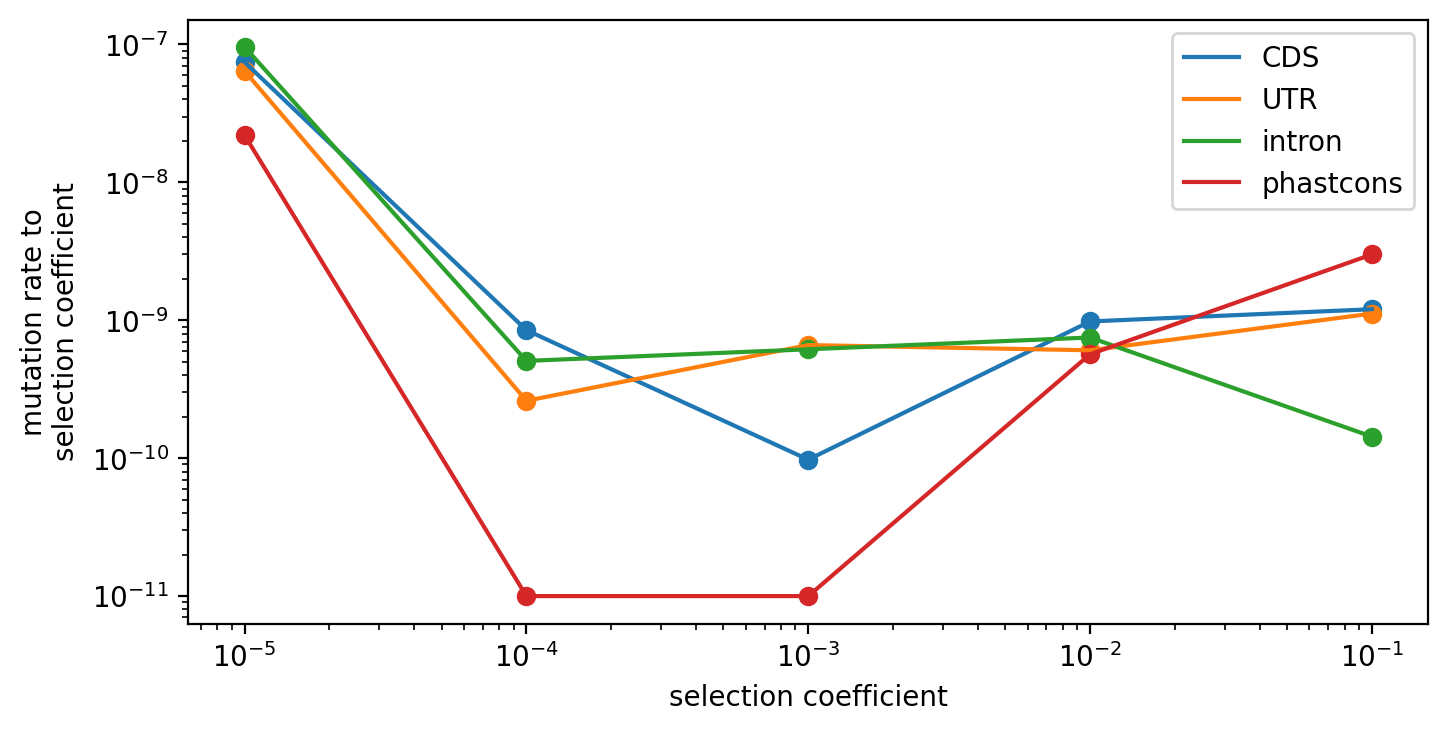

In [62]:
feats = {i: k for k, i in m.segments.feature_map.items()}
prop = mleBp.mle_W /mleBp.mle_W.sum(axis=0)
use_prop = False
for i in range(mleBp.mle_W.shape[1]):
    if use_prop:
        plt.plot(m.t, prop[:, i], label=f"{feats[i]}")
        plt.scatter(m.t, prop[:, i])
    else:
        plt.plot(m.t, mleBp.mle_W[:, i], label=f"{feats[i]}")
        plt.scatter(m.t, mleBp.mle_W[:, i])
plt.semilogy()
plt.legend()
plt.semilogx()
plt.xlabel('selection coefficient')
plt.ylabel('mutation rate to\nselection coefficient')

In [149]:
m.segments.feature_map

{'exon': 0, 'phastcons': 1}

In [72]:
tabulate(mleB.thetas_.mean(axis=0)[1:].reshape((4, 2)))

ValueError: cannot reshape array of size 15 into shape (4,2)

In [16]:
def meanscale(x):
    return x/np.nanmean(x)

ERROR! Session/line number was not unique in database. History logging moved to new session 1703
using neutral masks...
using accessibility masks...


AssertionError: InterpolatedMLE.theta_ is not set, call fit() first

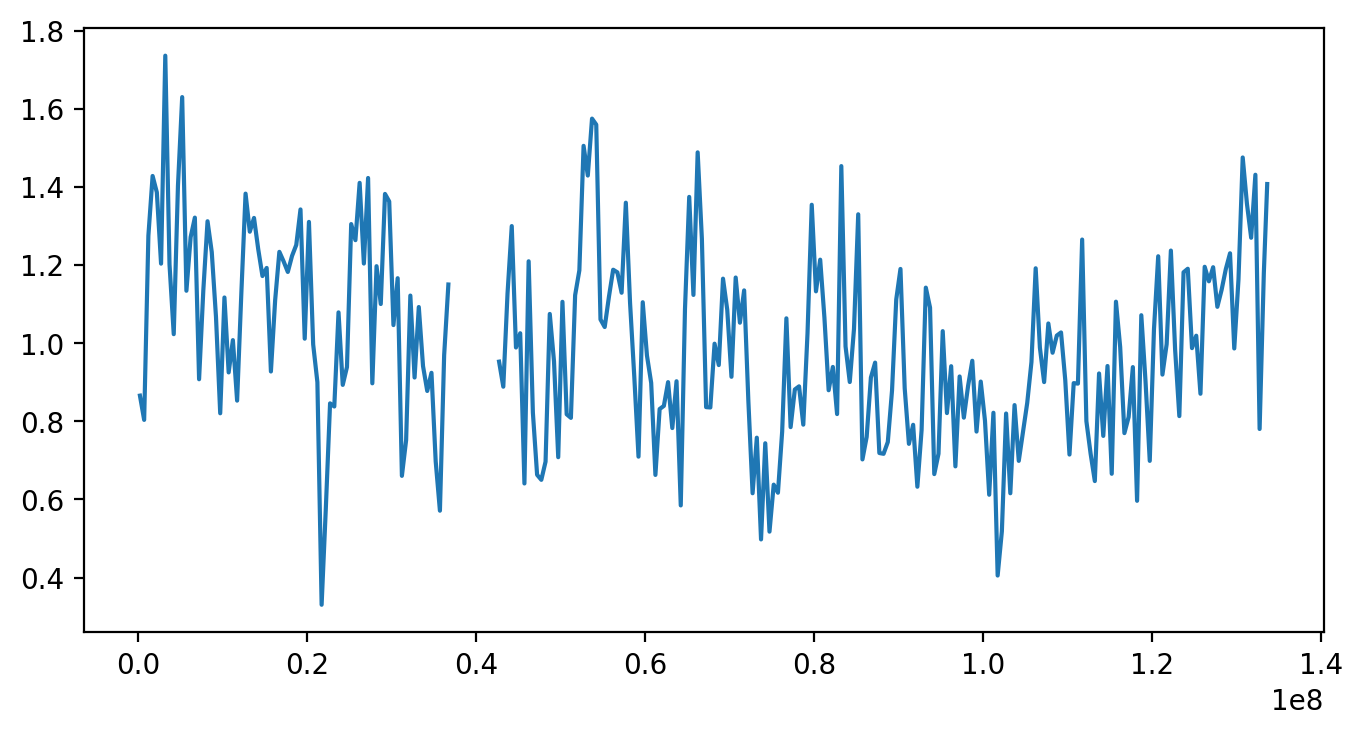

In [17]:
x, y = gd.bin_pi(5e5, filter_accessible=True, filter_neutral=True)[1]['chr10'].pairs
plt.plot(x, meanscale(y))

plt.plot(bins.midpoints['chr10'], meanscale(mleB.predict()), c='r', zorder=10)
plt.plot(bins.midpoints['chr10'], meanscale(mleBp.predict()), c='g', zorder=10)

pis = mle.predict(all=True)
#for i in range(mle.thetas_.shape[0]):
#    plt.plot(bins.midpoints['chr10'], pis[i, ...], c='0.22', alpha=0.1)



In [140]:
pi_pred_B = mleB.predict()
pi_pred_Bp = mleBp.predict()

In [141]:
n_pairs = Y.sum(axis=1)
pi = np.divide(Y[:, 1], n_pairs, where=(n_pairs!=0), out=np.full(n_pairs.shape[0], np.nan))

In [142]:
def R2(x, y):
    complete_idx = ~(np.isnan(x) | np.isnan(y))
    x = x[complete_idx]
    y = y[complete_idx]
    ssxm, ssxym, _, ssym = np.cov(x, y, bias=True).flat
    return ssxym / np.sqrt(ssxm * ssym)

In [143]:
R2(pi_pred_B, pi), R2(pi_pred_Bp, pi)

(0.5055183565210776, 0.5188016239269463)

In [163]:
np.log(1 - np.exp(np.finfo(float).minexp / np.log2(np.exp(1))))

0.0

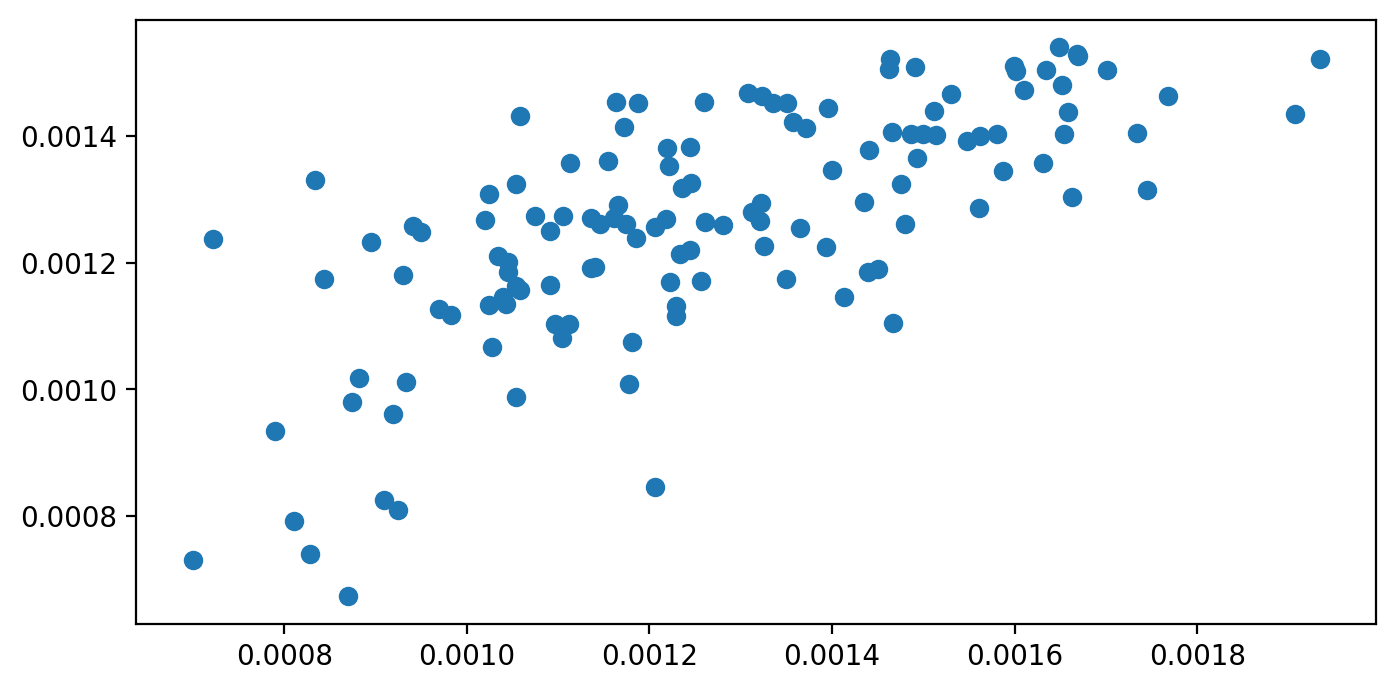

In [163]:
plt.scatter(pi, pi_pred)

In [141]:
np.corrcoef(y[~np.isnan(y)], pi_pred[~np.isnan(y)])

array([[1.        , 0.70241336],
       [0.70241336, 1.        ]])

In [116]:
mleB

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001764
  W = [[1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [6.109e-09]
    [6.880e-09]
    [8.734e-09]]
 negative log-likelihood: 315232376425.0403

In [117]:
mleBp

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001691
  W = [[8.405e-08]
    [9.254e-08]
    [6.181e-09]
    [8.697e-09]
    [5.106e-09]
    [1.000e-10]
    [8.775e-09]]
 negative log-likelihood: 315213192193.41486

In [328]:
import numba

In [357]:
from bgspy.likelihood import negll, negll_numba

In [358]:
%%timeit
negll_numba(mleBp.theta_, Y, Bp, m.w),

13.7 ms ± 659 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [359]:
%%timeit
negll(mleBp.theta_, Y, Bp, m.w)

135 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [361]:
negll_numba(mleBp.theta_, Y, Bp, m.w), negll(mleBp.theta_, Y, Bp, m.w)

(913624616281.9496, 913624616281.95)

In [319]:
mleBp.mle_W

array([[3.36999430e-08, 1.61469990e-09, 7.88808862e-09, 1.85524786e-08],
       [3.08752505e-10, 6.17946595e-10, 8.37286721e-10, 1.00000000e-10],
       [4.78833712e-10, 2.41454349e-10, 3.91060541e-10, 1.00000000e-10],
       [7.47722698e-10, 4.29517467e-10, 5.00873203e-10, 2.62840114e-09]])

In [108]:
mleB.thetas_.mean(axis=0), mleBp.thetas_.mean(axis=0)

(array([2.68653106e-03, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.95176760e-10, 2.22971303e-09, 5.11038049e-09, 1.65620432e-08]),
 array([1.70055522e-03, 5.69398369e-08, 7.65732902e-08, 5.13288339e-08,
        1.43732704e-09, 6.43607810e-10, 1.46868381e-09, 1.55566260e-08]))

In [112]:
mleB.mle_W.sum(), mleBp.mle_W.sum()

(1.8932801935219335e-08, 3.632471335715728e-08)

[]

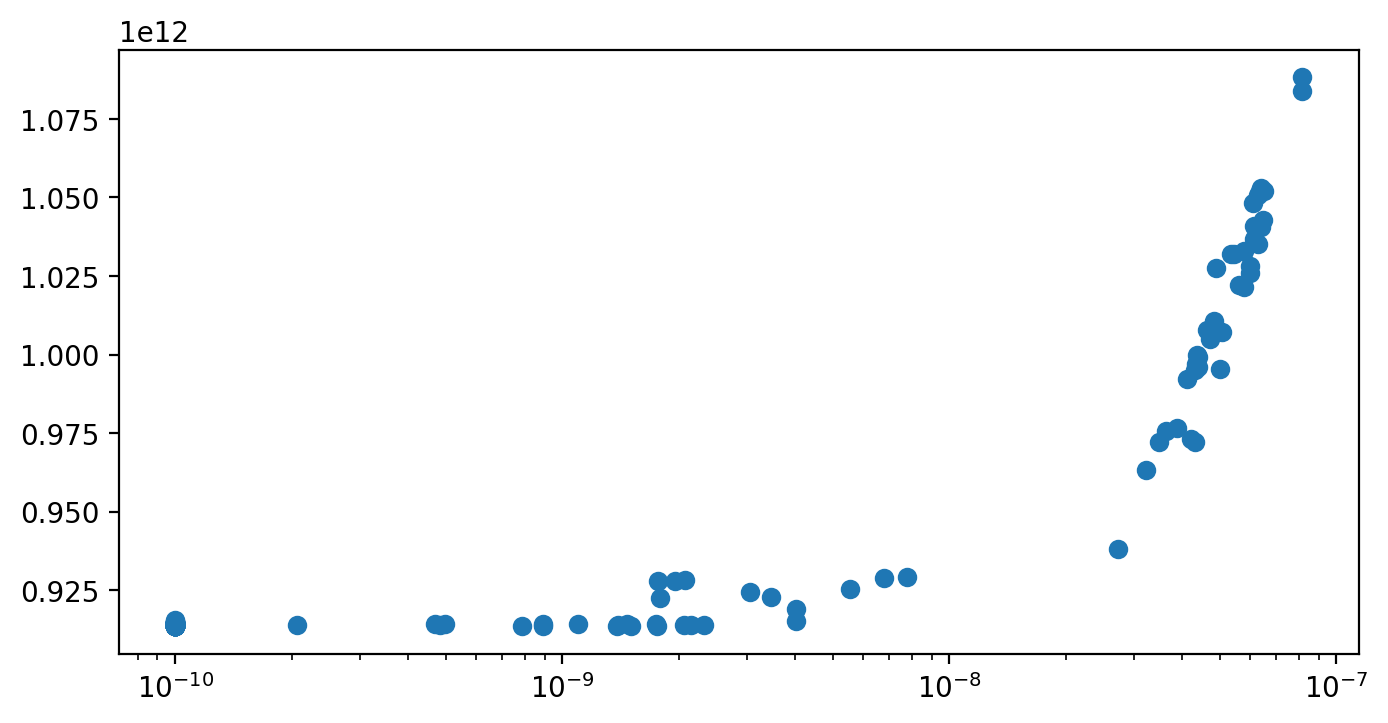

In [428]:
plt.scatter(mleBp.thetas_[:, 16], mleBp.nlls_)
plt.semilogx()
#plt.ylim(0.91e12, 0.925e12)

(913584973690.4689, 913586800862.2434)

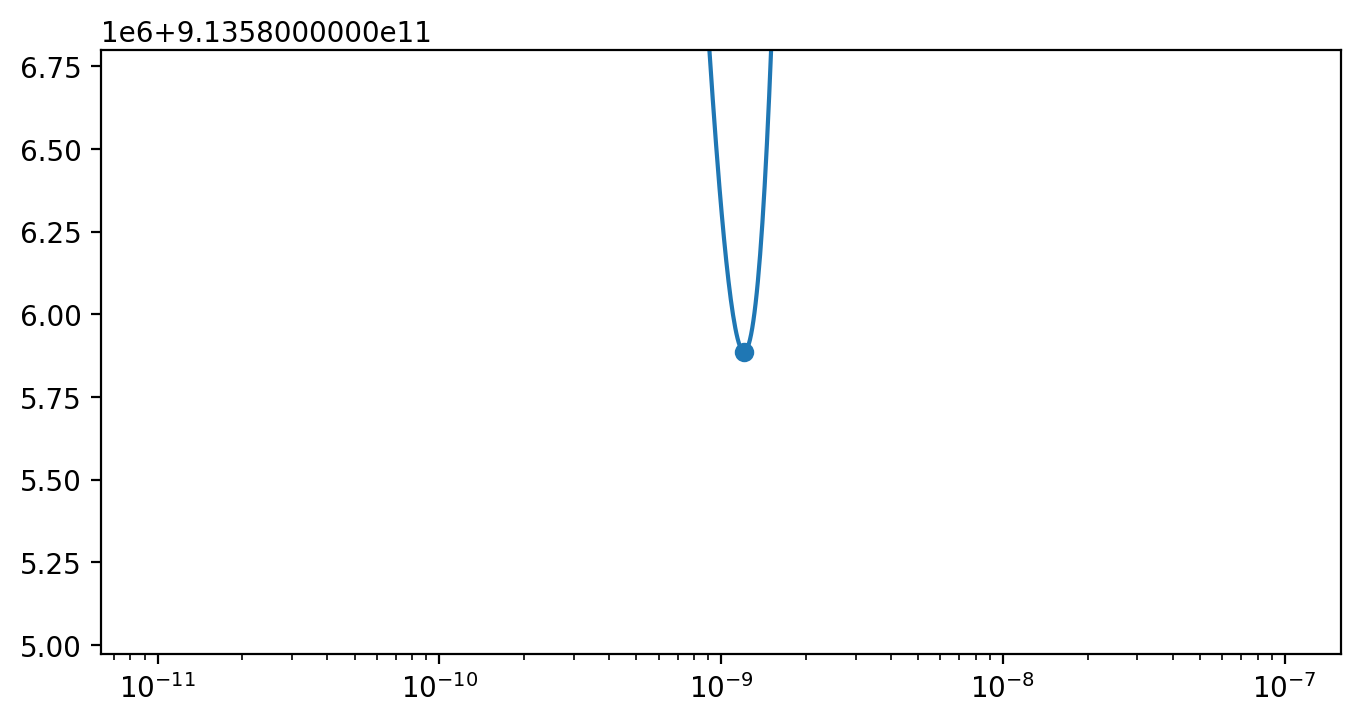

In [144]:
x = np.copy(mleBp.theta_)

res = []
alts = np.logspace(-11, -7, 1000)
Wi = np.arange(1, 13).reshape((4, 3))

for alt in alts:
    x[12] = alt
    res.append(negll_numba(x, Y, Bp, m.w))
    
plt.plot(alts, res)
plt.scatter(alts[np.argmin(res)], res[np.argmin(res)])
plt.semilogx()
plt.ylim(0.999999*np.min(res), np.min(res)*1.000001)

(913607986984.8777, 913609814202.6788)

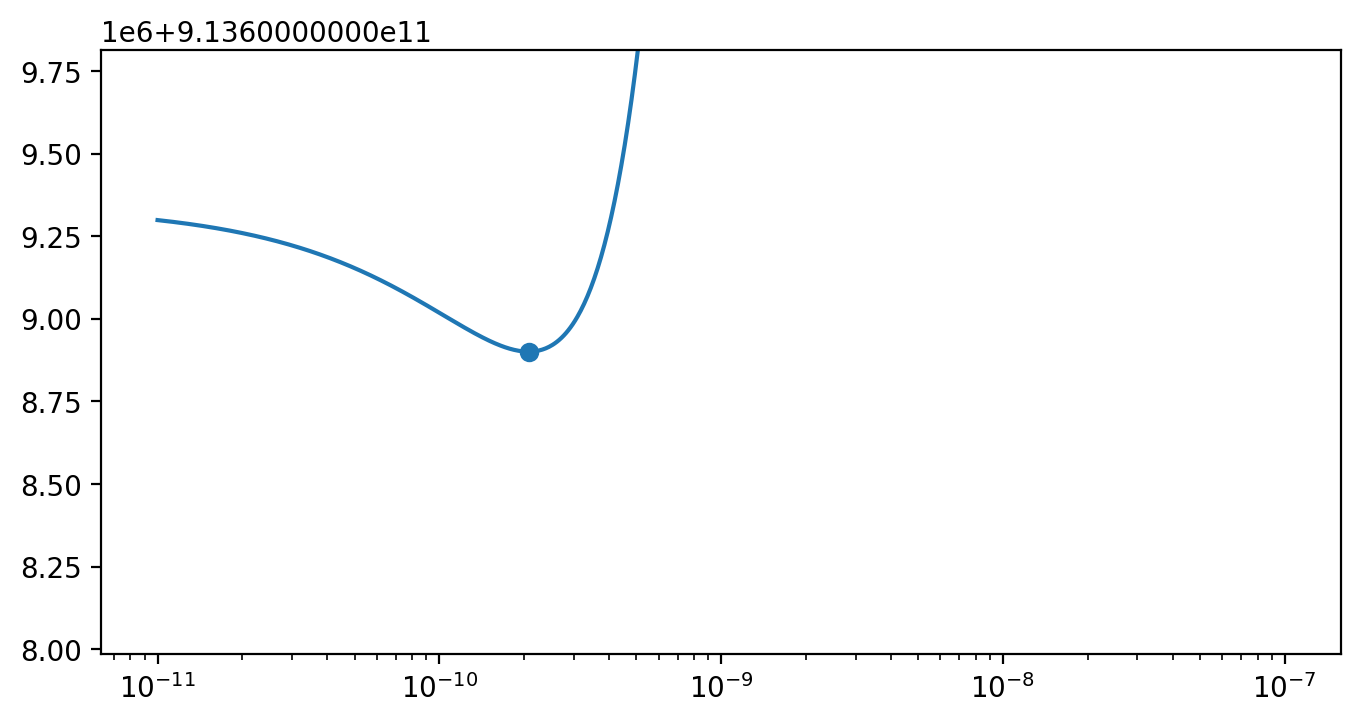

In [135]:
x = np.copy(mleBp.theta_)

res = []
alts = np.logspace(-11, -7, 1000)
Wi = np.arange(1, 13).reshape((4, 3))

for alt in alts:
    x[12] = alt
    res.append(negll_numba(x, Y, Bp, m.w))
    
plt.plot(alts, res)
plt.scatter(alts[np.argmin(res)], res[np.argmin(res)])
plt.semilogx()
plt.ylim(0.999999*np.min(res), np.min(res)*1.000001)

In [90]:
mleBp.mle_W

array([[6.90521589e-09, 6.48376016e-09, 3.98241354e-08],
       [1.52770666e-10, 5.03188410e-11, 9.01215713e-11],
       [1.95296546e-10, 1.06676750e-10, 2.30567085e-10],
       [1.70939337e-10, 2.60831630e-10, 2.33476164e-10],
       [3.94436696e-09, 2.52853612e-09, 1.73215550e-09]])

In [95]:
np.arange(1, 13).reshape((4, 3))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [501]:
bps = (g.segments.lengths[:, None] * g.segments.F).sum(axis=0)
bps / bps.sum()

array([0.0286892 , 0.01034282, 0.00757465, 0.95339333])

In [480]:
wopt

array([[2.20388268e-10, 2.83584787e-10, 2.55601873e-10, 3.37011217e-08],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10],
       [2.60632369e-10, 1.00000000e-10, 1.00000000e-10, 2.22480467e-10],
       [2.26802133e-10, 1.01064185e-10, 2.50947480e-10, 1.94755219e-09]])

In [303]:
np.arange(mleBp.theta_.size)[1:].reshape(4, 4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [289]:
mle = mleBp
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[0] = np.nan
pgrid[6] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[51, None, None, None, None, None, 50, None])

cmap = mpl.cm.get_cmap('viridis_r')
p1, p2 = 0, 6

x, y, z = grid[p1], grid[p2], nlls.reshape((51, 50))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

#cmap = mpl.cm.get_cmap('viridis_r')

fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=z.max()))
ax.scatter(np.log10(mle.theta_[p1]), np.log10(mle.theta_[p2]), c='r')
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, p1], mle.thetas_[i, p2], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$\pi_0$')
plt.ylabel('$w_{5, 0}$')
plt.loglog()

IndexError: list index out of range

[]

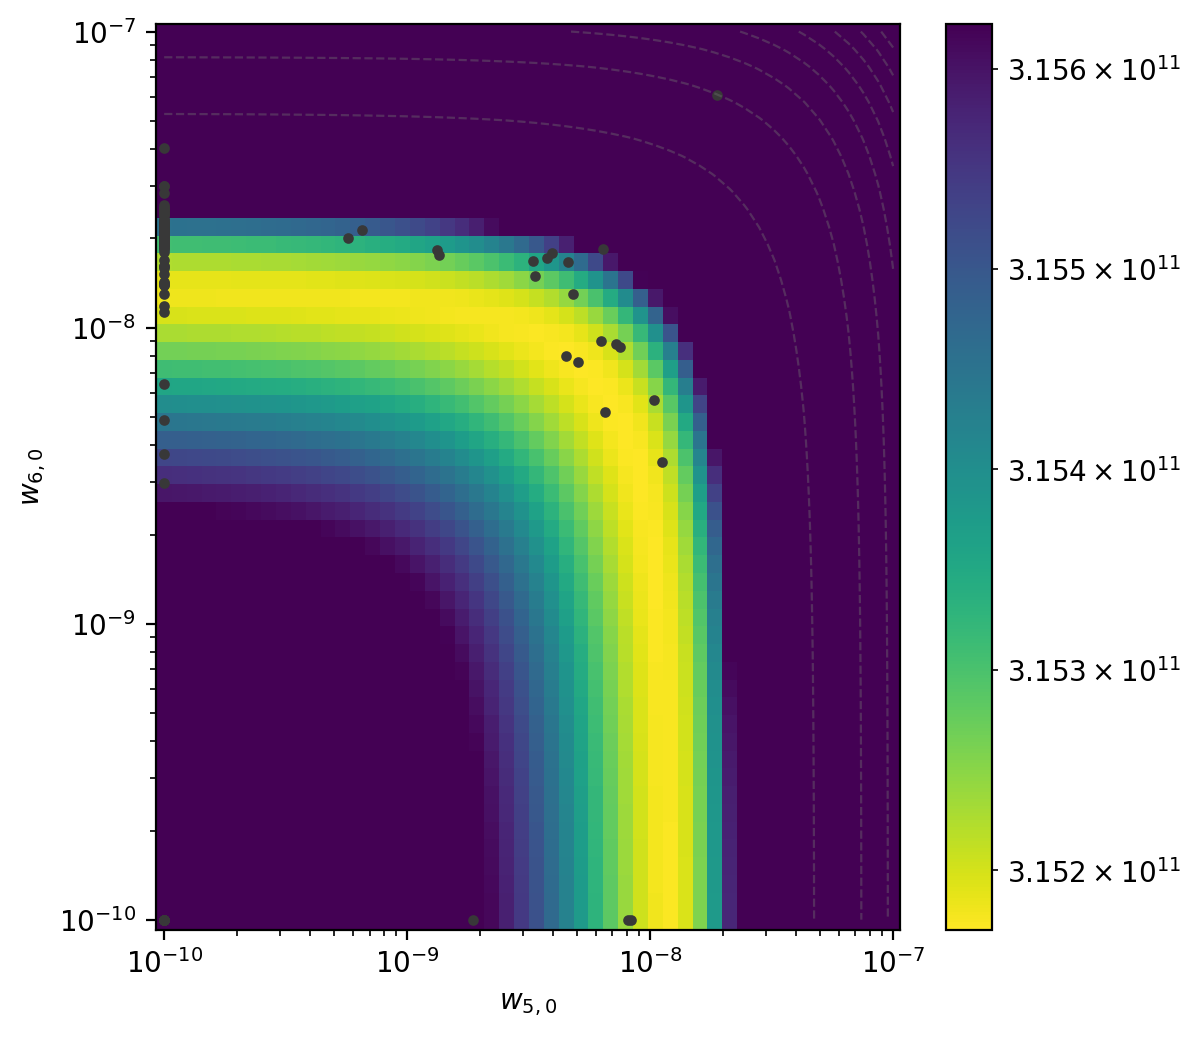

In [57]:
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[6:8] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[None, None, None, None, None, None, 50, 51])

x, y, z = grid[6], grid[7], nlls.reshape((50, 51))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

cmap = mpl.cm.get_cmap('viridis_r')

# note on transpose: this is because the number of columns of C must match number of elements of x
fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=np.quantile(z, 0.4)))
ax.scatter(np.log10(mle.theta_[6]), np.log10(mle.theta_[7]))
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, 6], mle.thetas_[i, 7], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$w_{5, 0}$')
plt.ylabel('$w_{6, 0}$')
plt.loglog()